In [1]:
import numpy as np
import pandas as pd
import os

import math
from scipy.stats import spearmanr

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
import seaborn as sns

# 1. 데이터 불러오기

In [2]:
df_train = pd.read_csv('../energy/train.csv', encoding='cp949')
df_test = pd.read_csv('../energy/test.csv', encoding='cp949')

In [3]:
train = df_train.copy()
test = df_test.copy()

In [4]:
train.head()

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0


In [5]:
test.head()

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 2. 데이터 전처리

## 2-1. 컬럼 이름 변경

In [6]:
cols = ["num", "date_time", "energy", "temp", "windspeed", "humidity", "precipitation", "sun", "cooler", "solar"]
cols2 = ["num", "date_time", "temp", "windspeed", "humidity", "precipitation", "sun", "cooler", "solar"]


train.columns = cols
test.columns = cols2

In [7]:
train.head()

,num,date_time,energy,temp,windspeed,humidity,precipitation,sun,cooler,solar
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0


In [8]:
test.head()

,num,date_time,temp,windspeed,humidity,precipitation,sun,cooler,solar
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2-2. 결측치 처리

In [9]:
train.isnull().sum()

num              0
date_time        0
energy           0
temp             0
windspeed        0
humidity         0
precipitation    0
sun              0
cooler           0
solar            0
dtype: int64

In [10]:
test.isnull().sum()

num                 0
date_time           0
temp             6720
windspeed        6720
humidity         6720
precipitation    8400
sun              6720
cooler           7784
solar            8456
dtype: int64

### test 데이터에 한해서 결측치 처리 진행

- **수치형 데이터 결측치 처리**

분석 데이터가 시계열데이터이기 때문에 단순히 특정 값을 대입하기보다 
    
해당 결측치의 앞, 뒤 값에 선형적으로 비례하는 **interpolate 함수**를 사용하여 수치형 데이터 컬럼의 결측치를 처리했다.

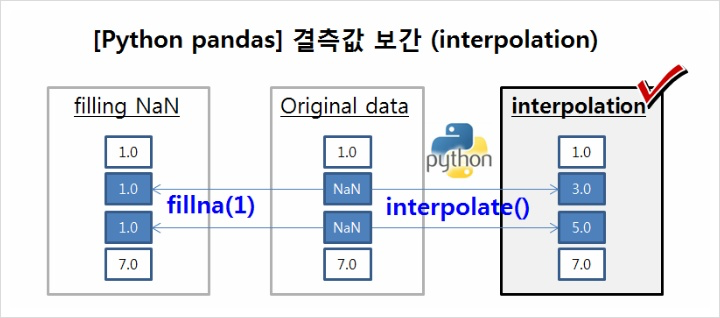

In [11]:
# 수치 데이터 결측치 보간하기
test[["temp", "windspeed", "humidity", "precipitation", "sun"]] = test[["temp", "windspeed", "humidity", "precipitation", "sun"]].interpolate(method="values")
pd.options.display.float_format = '{:.2f}'.format
test.head(10)

,num,date_time,temp,windspeed,humidity,precipitation,sun,cooler,solar
0,1,2020-08-25 00,27.80,1.50,74.00,0.00,0.00,NaN,NaN
1,1,2020-08-25 01,27.63,1.37,75.33,0.00,0.00,NaN,NaN
2,1,2020-08-25 02,27.47,1.23,76.67,0.00,0.00,NaN,NaN
3,1,2020-08-25 03,27.30,1.10,78.00,0.00,0.00,NaN,NaN
4,1,2020-08-25 04,26.90,1.17,79.67,0.00,0.00,NaN,NaN
5,1,2020-08-25 05,26.50,1.23,81.33,0.00,0.00,NaN,NaN
6,1,2020-08-25 06,26.10,1.30,83.00,0.00,0.00,NaN,NaN
7,1,2020-08-25 07,27.00,1.27,81.00,0.00,0.37,NaN,NaN
8,1,2020-08-25 08,27.90,1.23,79.00,0.00,0.73,NaN,NaN
9,1,2020-08-25 09,28.80,1.20,77.00,0.00,1.10,NaN,NaN


In [12]:
test.isnull().sum()

num                 0
date_time           0
temp                0
windspeed           0
humidity            0
precipitation       0
sun                 0
cooler           7784
solar            8456
dtype: int64

- **범주형 데이터 결측치 처리**

cooler(비전기냉방시설), solar(태양광보유) 컬럼의 경우 범주형 데이터이며 결측치를 제외한 모든 값은 1이다.

이는 해당 시설이 존재할 경우 1이며, 존재하지 않을 경우 결측치로 입력되어있는 것으로 유추할 수 있고,
  
따라서 **결측치를 0**으로 처리했다.

In [13]:
test = test.fillna(0)

In [14]:
test.isnull().sum()

num              0
date_time        0
temp             0
windspeed        0
humidity         0
precipitation    0
sun              0
cooler           0
solar            0
dtype: int64

In [15]:
test.head()

,num,date_time,temp,windspeed,humidity,precipitation,sun,cooler,solar
0,1,2020-08-25 00,27.80,1.50,74.00,0.00,0.00,0.00,0.00
1,1,2020-08-25 01,27.63,1.37,75.33,0.00,0.00,0.00,0.00
2,1,2020-08-25 02,27.47,1.23,76.67,0.00,0.00,0.00,0.00
3,1,2020-08-25 03,27.30,1.10,78.00,0.00,0.00,0.00,0.00
4,1,2020-08-25 04,26.90,1.17,79.67,0.00,0.00,0.00,0.00


## 2-3. 시간 데이터

- date_time 컬럼 datetime으로 type 변환

In [16]:
train["date_time"] = pd.to_datetime(train["date_time"])

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   num            122400 non-null  int64         
 1   date_time      122400 non-null  datetime64[ns]
 2   energy         122400 non-null  float64       
 3   temp           122400 non-null  float64       
 4   windspeed      122400 non-null  float64       
 5   humidity       122400 non-null  float64       
 6   precipitation  122400 non-null  float64       
 7   sun            122400 non-null  float64       
 8   cooler         122400 non-null  float64       
 9   solar          122400 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 9.3 MB


In [18]:
train["date"] = train["date_time"].dt.date # 전체 날짜
train["month"] = train["date_time"].dt.month # 월
train["day"] = train["date_time"].dt.day # 일
train["hour"] = train["date_time"].dt.hour
train["weekday"] = train["date_time"].dt.weekday # 0: 월요일
train["weekend"] = train["weekday"].isin([5, 6]).astype(int) # 5: 토요일

train.head()

,num,date_time,energy,temp,windspeed,humidity,precipitation,sun,cooler,solar,date,month,day,hour,weekday,weekend
0,1,2020-06-01 00:00:00,8179.06,17.60,2.50,92.00,0.80,0.00,0.00,0.00,2020-06-01,6,1,0,0,0
1,1,2020-06-01 01:00:00,8135.64,17.70,2.90,91.00,0.30,0.00,0.00,0.00,2020-06-01,6,1,1,0,0
2,1,2020-06-01 02:00:00,8107.13,17.50,3.20,91.00,0.00,0.00,0.00,0.00,2020-06-01,6,1,2,0,0
3,1,2020-06-01 03:00:00,8048.81,17.10,3.20,91.00,0.00,0.00,0.00,0.00,2020-06-01,6,1,3,0,0
4,1,2020-06-01 04:00:00,8043.62,17.00,3.30,92.00,0.00,0.00,0.00,0.00,2020-06-01,6,1,4,0,0


In [19]:
test["date_time"] = pd.to_datetime(test["date_time"])

In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   num            10080 non-null  int64         
 1   date_time      10080 non-null  datetime64[ns]
 2   temp           10080 non-null  float64       
 3   windspeed      10080 non-null  float64       
 4   humidity       10080 non-null  float64       
 5   precipitation  10080 non-null  float64       
 6   sun            10080 non-null  float64       
 7   cooler         10080 non-null  float64       
 8   solar          10080 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 708.9 KB


In [21]:
test["date"] = test["date_time"].dt.date # 전체 날짜
test["month"] = test["date_time"].dt.month # 월
test["day"] = test["date_time"].dt.day # 일
test["hour"] = test["date_time"].dt.hour
test["weekday"] = test["date_time"].dt.weekday # 0: 월요일
test["weekend"] = test["weekday"].isin([5, 6]).astype(int) # 5: 토요일

test.head()

,num,date_time,temp,windspeed,humidity,precipitation,sun,cooler,solar,date,month,day,hour,weekday,weekend
0,1,2020-08-25 00:00:00,27.80,1.50,74.00,0.00,0.00,0.00,0.00,2020-08-25,8,25,0,1,0
1,1,2020-08-25 01:00:00,27.63,1.37,75.33,0.00,0.00,0.00,0.00,2020-08-25,8,25,1,1,0
2,1,2020-08-25 02:00:00,27.47,1.23,76.67,0.00,0.00,0.00,0.00,2020-08-25,8,25,2,1,0
3,1,2020-08-25 03:00:00,27.30,1.10,78.00,0.00,0.00,0.00,0.00,2020-08-25,8,25,3,1,0
4,1,2020-08-25 04:00:00,26.90,1.17,79.67,0.00,0.00,0.00,0.00,2020-08-25,8,25,4,1,0


# 3. Feature Engineering

## 3-1. 불쾌지수

### 1.8$T$ − 0.55(1−$RH$)(1.8$T$−26) + 32

$T$=기온(°C), $RH$=상대습도(%)

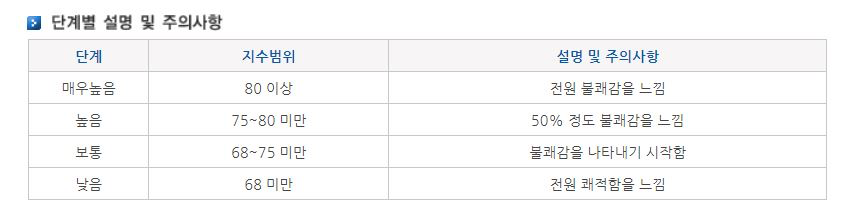

- 기온과 습도의 조합으로 사람이 느끼는 온도를 표현한 것으로 온습도지수(THI)
- 불쾌지수는 복사나 바람의 조건은 포함되어 있지 않기 때문에 그 적정한 사용에는 한계가 있다.
- **해당 데이터가 여름철 데이터인만큼 전력사용량과 관련이 있을 것**이라고 판단

In [22]:
train['THI'] = 1.8*train['temp'] - 0.55*(1-(train['humidity']/100))*(1.8*train['temp']-26) + 32
test['THI'] = 1.8*test['temp'] - 0.55*(1-(test['humidity']/100))*(1.8*test['temp']-26) + 32

## 3-2. 체감온도

### 13.12 + 0.6125$T$ − 13.947$V^{0.16}$ + 0.486$T$$V^{0.16}$ 

$T$=기온(°C), $V$=풍속(m/s)

- 체감온도는 불쾌지수에서 포함하지 않은 **바람의 조건을 포함**하고 있어 불쾌지수를 보완해주는 변수라고 판단했다.

In [23]:
train['sensible'] = 13.12+0.6215*train['temp']-13.947*train['windspeed']**0.16+0.486*train['temp']*train['windspeed']**0.16
test['sensible'] = 13.12+0.6215*test['temp']-13.947*test['windspeed']**0.16+0.486*test['temp']*test['windspeed']**0.16

## 3-3. CDH (Cooling Dgree Hour, 냉방도일)

∑(일평균기온－24(°C))

- **도일(degree day)**: 외부 기온과 실내 기온의 차와 이에 따라 소요되는 연료 소비를 고려한 기후 수치

- **냉방도일(Cooling Degree Day)**: '일평균기온 > 기존 온도'인 날들의 일평균기온 - 기준 온도와를 구해 매일 누적 합산한 것


- **여기선 Day가 아닌 Hour로 각 시간별 온도와 기준 온도의 차를 적산**하였다.


- 냉방 수요에 대한 설명력이 높은 변수이기 때문에 추가

In [24]:
def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11: 
            ys.append(np.sum(xs[:(i+1)] - 26))
        else:
            ys.append(np.sum(xs[(i-1): (i+1)] - 26))
    return np.array(ys)

In [25]:
def make_CDH(df):
    cdh_str = np.array([])
    for num in range(1, 61):
        temp = df[df["num"] == num]
        cdh = CDH(temp["temp"].values)
        cdh_str = np.concatenate([cdh_str, cdh])
    return cdh_str

# CDH 열 생성
train["CDH"] = make_CDH(train)
test["CDH"] = make_CDH(test)

# 4. 건물별 분석 

In [26]:
train

,num,date_time,energy,temp,windspeed,humidity,precipitation,sun,cooler,solar,date,month,day,hour,weekday,weekend,THI,sensible,CDH
0,1,2020-06-01 00:00:00,8179.06,17.60,2.50,92.00,0.80,0.00,0.00,0.00,2020-06-01,6,1,0,0,0,63.43,17.81,-8.40
1,1,2020-06-01 01:00:00,8135.64,17.70,2.90,91.00,0.30,0.00,0.00,0.00,2020-06-01,6,1,1,0,0,63.57,17.78,-16.70
2,1,2020-06-01 02:00:00,8107.13,17.50,3.20,91.00,0.00,0.00,0.00,0.00,2020-06-01,6,1,2,0,0,63.23,17.44,-25.20
3,1,2020-06-01 03:00:00,8048.81,17.10,3.20,91.00,0.00,0.00,0.00,0.00,2020-06-01,6,1,3,0,0,62.54,16.96,-34.10
4,1,2020-06-01 04:00:00,8043.62,17.00,3.30,92.00,0.00,0.00,0.00,0.00,2020-06-01,6,1,4,0,0,62.40,16.80,-43.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19:00:00,4114.37,27.80,2.30,68.00,0.00,0.70,1.00,1.00,2020-08-24,8,24,19,0,0,77.81,29.90,4.30
122396,60,2020-08-24 20:00:00,3975.70,27.30,1.20,71.00,0.00,0.00,1.00,1.00,2020-08-24,8,24,20,0,0,77.45,29.39,3.10
122397,60,2020-08-24 21:00:00,3572.21,27.30,1.80,71.00,0.00,0.00,1.00,1.00,2020-08-24,8,24,21,0,0,77.45,29.34,2.60
122398,60,2020-08-24 22:00:00,3299.18,27.10,1.80,74.00,0.00,0.00,1.00,1.00,2020-08-24,8,24,22,0,0,77.52,29.11,2.40


In [27]:
train.describe()

,num,energy,temp,windspeed,humidity,precipitation,sun,cooler,solar,month,day,hour,weekday,weekend,THI,sensible,CDH
count,122400.00,122400.00,122400.00,122400.00,122400.00,122400.00,122400.00,122400.00,122400.00,122400.00,122400.00,122400.00,122400.00,122400.00,122400.00,122400.00,122400.00
mean,30.50,2324.83,24.25,2.15,80.17,0.51,0.21,0.68,0.48,6.93,14.84,11.50,2.96,0.28,73.46,25.94,-3.68
std,17.32,2059.00,3.41,1.51,15.53,2.62,0.37,0.47,0.50,0.79,8.45,6.92,2.01,0.45,4.78,3.87,7.69
min,1.00,0.00,11.10,0.00,19.00,0.00,0.00,0.00,0.00,6.00,1.00,0.00,0.00,0.00,52.34,11.94,-101.40
25%,15.75,1055.27,21.80,1.10,70.00,0.00,0.00,0.00,0.00,6.00,8.00,5.75,1.00,0.00,70.04,23.17,-8.40
50%,30.50,1700.35,24.20,1.90,84.00,0.00,0.00,1.00,0.00,7.00,15.00,11.50,3.00,0.00,73.62,25.85,-3.70
75%,45.25,2780.49,26.50,2.90,93.00,0.00,0.30,1.00,1.00,8.00,22.00,17.25,5.00,1.00,77.07,28.46,1.00
max,60.00,17739.22,36.30,20.10,100.00,81.50,1.00,1.00,1.00,8.00,31.00,23.00,6.00,1.00,86.66,39.70,19.90


## 4-1. 건물들의 평균 전력 사용량

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


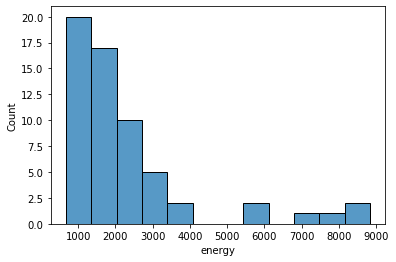

In [28]:
sns.histplot(train.groupby('num')['energy'].mean());

평균적으로 1000-3000kWh 정도의 전력을 사용하고, 9000kWh를 쓰는 건물까지 있는 것으로 보아 전력사용량의 총량이 매우 다양하다는 것을 확인했다.

## 4-2. 일별 평균 기온과 전력 사용량

In [29]:
# 연 기준 며칠째인지
train['dayofyear'] = train.date_time.dt.dayofyear 
test['dayofyear'] = test.date_time.dt.dayofyear 

분석 데이터는 시계열 데이터이다. 이러한 시계열성(순차적인 데이터)을 시각화하기 위해 단순 날짜인 day보다

시간의 경과를 내포하고 있는 **dayofweek**을 사용해 데이터를 시각화하고자 한다.

- 6월 : 153 ~ 182

- 7월 : 183 ~ 213

- 8월 : 214 ~ 237

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
/Users/yeon/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/yeon/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/yeon/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/yeon/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 44512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/yeon/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, fla

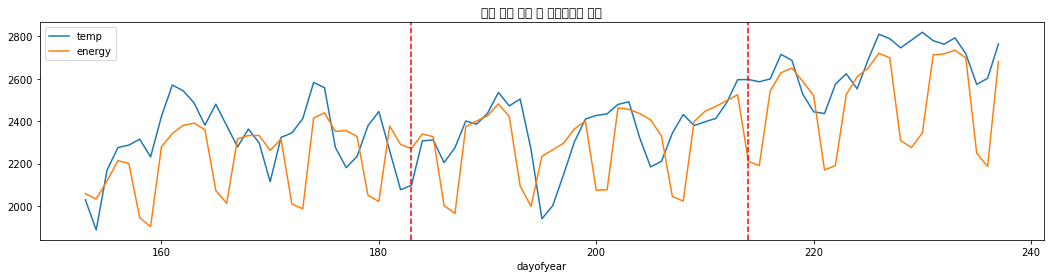

In [30]:
(train.groupby(['dayofyear'])['temp'].mean()*100).plot(figsize=(18, 4))
                                          # 왜 100을 곱하지????? -> 단위를 맞춰주려고
train.groupby(['dayofyear'])['energy'].mean().plot(figsize=(18, 4))
plt.legend(['temp', 'energy'])
plt.axvline(x = 183, color = 'r', linestyle = '--',)  # 7월 시작
plt.axvline(x = 214, color = 'r', linestyle = '--',)  # 8월 시작
plt.title('일별 평균 기온 및 전력사용량 추이')
plt.show()

빨간 점선 : 6, 7, 8월 구분

**7월 초순 이후로 꾸준히 상승하는 경향을 보이며, 일반적으로 전력 사용량은 기온과 비슷한 양상**을 보인다.

## 4-3. 일별 평균 습도 및 기온 추이

/Users/yeon/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/yeon/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/yeon/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/yeon/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 44512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/yeon/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/yeon/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backe

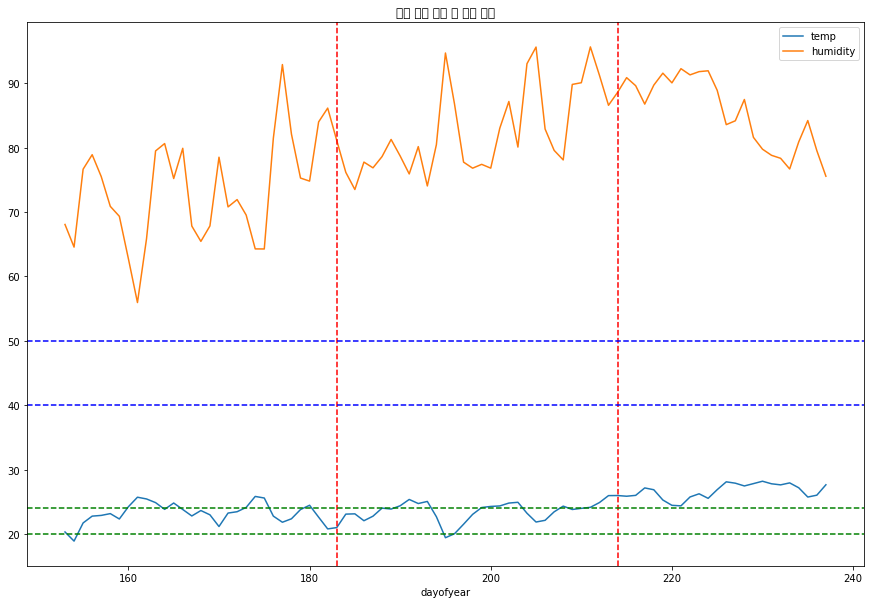

In [31]:
(train.groupby(['dayofyear'])['temp'].mean()).plot(figsize=(15, 10))
train.groupby(['dayofyear'])['humidity'].mean().plot(figsize=(15, 10))
plt.legend(['temp', 'humidity'])


plt.axvline(x = 183, color = 'r', linestyle = '--',)  # 7월 시작
plt.axvline(x = 214, color = 'r', linestyle = '--',)  # 8월 시작

plt.axhline(y = 20, color = 'g', linestyle = '--',)  # 20°C
plt.axhline(y = 24, color = 'g', linestyle = '--',)  # 24°C

plt.axhline(y = 40, color = 'b', linestyle = '--',)  # 40%
plt.axhline(y = 50, color = 'b', linestyle = '--',)  # 50%


plt.title('일별 평균 기온 및 습도 추이')
plt.show()

- 여름 적정 실내온도와 습도는? : https://www.korea.kr/news/healthView.do?newsId=148780861
 
위 기사에 따르면 쾌적함을 주는 습도는 온도에 따라 달라지는데,

15°C에서는 70%정도, 18-20°C에서는 60%, 21-23°C에서는 50%, 24°C이상에서는 40%가 적당한 습도라고 한다.

실내 기준이지만, 사람이 쾌적함을 느낀다는 점에서 실외 온도, 습도에 대해서도 동일하게 적용할 수 있는 기준이라고 생각한다.

train 데이터에는 대체적으로 20-30°C 사이의 기온이다.

그렇다면 해당 기온에서는 40-50%의 습도가 적정 습도라고 볼 수 있는데,

그보다 한참 높은 평균 80% 정도의 습도가 형성되어 있다.

더불어 기온이 상승함에 따라 습도 또한 상승하는 양상을 보이므로 **습도가 증가하면 전력 사용량이 증가하는 양상**을 보일 것이라고 예측할 수 있다.


## 4-4. 일별 강수량 추이

/Users/yeon/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 44053 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/yeon/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/yeon/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/yeon/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 44053 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/yeon/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/yeon/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/

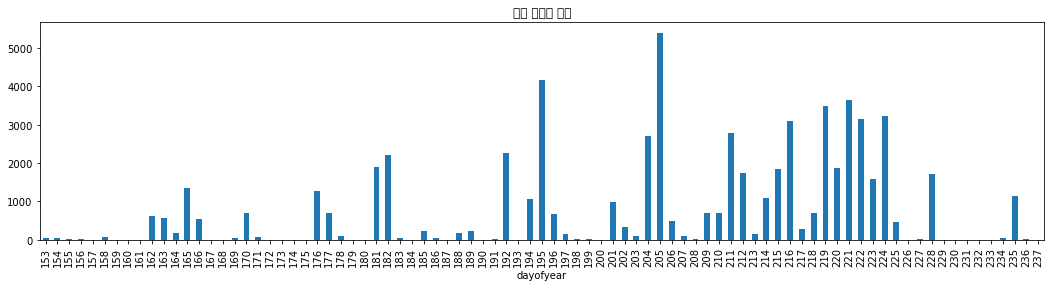

In [32]:
(train.groupby(['dayofyear'])['precipitation'].sum()).plot(kind='bar', figsize=(18, 4))
plt.title('일별 강수량 추이')
plt.show()

7월 말부터 8월 중순(204 ~ 224) 까지는 거의 매일 비가 내린 것을 알 수 있다.

이는 장마기간으로 예측할 수 있다.

## 4-5. 일별 일조량 추이

/Users/yeon/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51312 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/yeon/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 51312 missing from current font.
  font.set_text(s, 0, flags=flags)


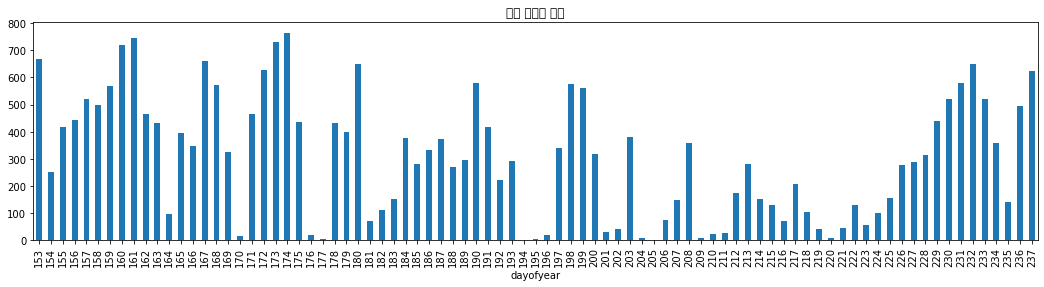

In [33]:
train.groupby(['dayofyear'])['sun'].sum().plot(kind='bar', figsize=(18, 4))
plt.title('일별 일조량 추이')
plt.show()

장마 시즌(204-224)에는 일조시간이 줄어들며, 6월(153-182)과 8월 말(229-237)에 높은 일조시간을 보이는 것을 알 수 있다.

이를 통해 강수량과 일조량은 **강수량이 증가하면 일조량은 낮아지는 trade-off 관계**일 것이라고 생각된다.

### 위 분석을 통해 알 수 있는 것은 다음과 같다.

- 6월, 7월보다 8월 말로 갈수록 더욱 기온은 높아진다.


- 기온과 습도가 높아짐에 따라 전력 사용량도 같이 높아지는 경향이 있다.


- 7월 말부터 장마의 영향을 받으며 비내리는 날이 많아진다.


- 8월 말에는 장마가 끝나며, 비가 오는 날이 거의 없다.


- 일조 시간은 6월에 가장 높았고, 장마 시즌에 줄어들었으며, 8월에 다시 오르고 있다.

## 4-6. 시간대별 평균 전력 사용량

/Users/yeon/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/yeon/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 44036 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/yeon/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 45824 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/yeon/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/yeon/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 47141 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/yeon/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backe

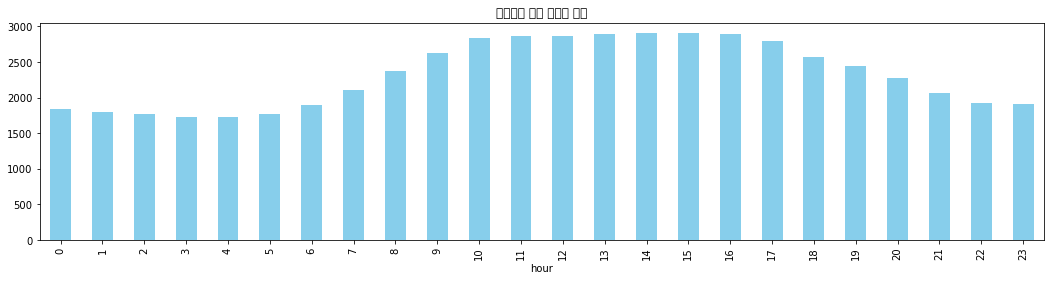

In [34]:
train.groupby(['hour'])['energy'].mean().plot(kind='bar', color='skyblue', figsize=(18, 4))
plt.title('시간대별 전력 사용량 추이')
plt.show()

시간대별 평균 전력 사용량 추이를 확인해본 결과 **13-16시에 가장 많은 전력을 사용**하는 것을 알 수 있다. 

## 4-7. 비전기 냉방 시설(Cooler) 설치 여부에 따른 전력 사용량
- 비전기 냉방 시설의 설치 여부에 따른 동일 시간대(피크 시간) 전력 사용량을 산점도로 비교

- 4-6에서 구한 여름철 피크 시간대(14시)

분석 데이터가 시계열 데이터이므로 **8월의 전력 사용량**을 통해 비교를 진행하고자 한다.

6, 7월의 경우 아직 비전기 냉방 시설을 설치하지 않았을 수도 있고,

일반적으로 비전기 냉방 시설을 6, 7월에 설치했다가 8월에 제거했을 경우는 거의 없을 것이라고 생각되기 때문이다.

In [35]:
# 'energy' 스케일링
for i in range(1, 61):
    mean_ = train.loc[train.num == i].energy.mean()
    std_ = train.loc[train.num == i].energy.std()
    train.loc[train.num == i, 'energy_sc'] = ((train.loc[train.num == i, 'energy']) - mean_) / std_
print(train['energy_sc'])

0        -2.80
1        -3.13
2        -3.35
3        -3.80
4        -3.84
          ... 
122395    1.84
122396    1.50
122397    0.53
122398   -0.13
122399   -0.36
Name: energy_sc, Length: 122400, dtype: float64


In [36]:
# 여름철 피크 시간대 14시
peak_df_1_8 = train.loc[(train.month == 8) & (train.hour == 14) & (train.cooler == 1)]
peak_df_0_8 = train.loc[(train.month == 8) & (train.hour == 14) & (train.cooler == 0)]

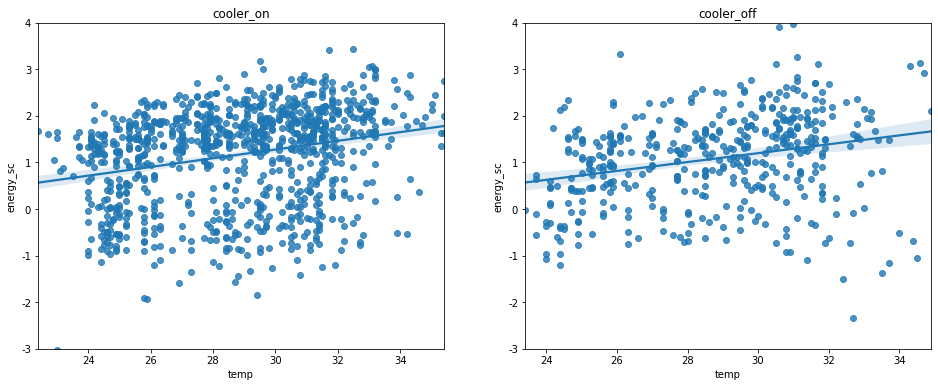

In [37]:
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.title("cooler_on")
sns.regplot(data=peak_df_1_8, x='temp', y='energy_sc')
plt.ylim(top=4, bottom=-3)

plt.subplot(1, 2, 2)
plt.title("cooler_off")
sns.regplot(data=peak_df_0_8, x='temp', y='energy_sc')
plt.ylim(top=4, bottom=-3)

plt.show()

- **Cooler 설치 건물 개별 시각화**

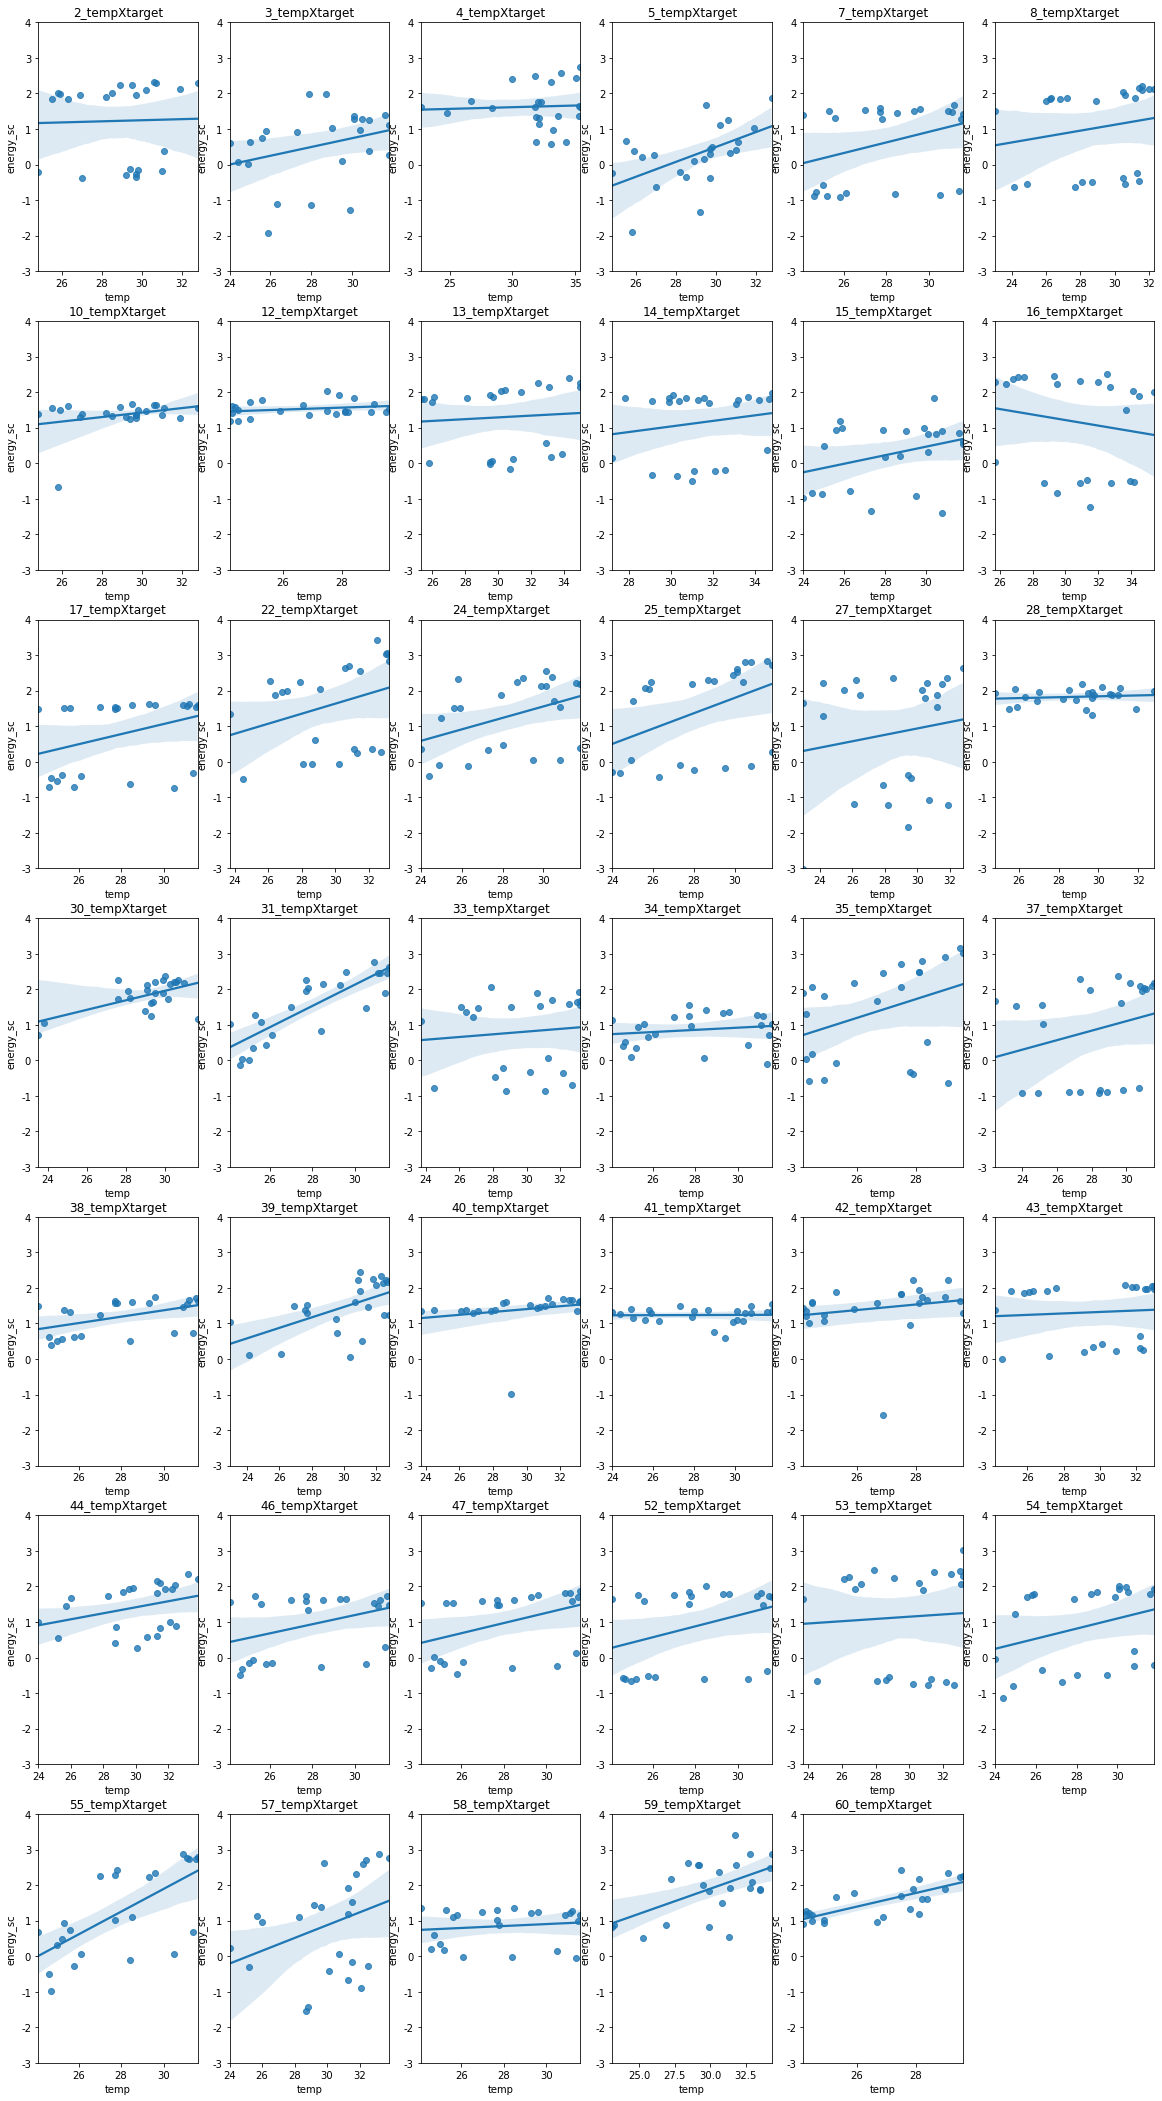

In [38]:
fig = plt.figure(figsize=(20, 65))
for i, n in enumerate(peak_df_1_8.num.unique()):
    plt.subplot(12, 6, i+1)
    plt.title("{}_tempXtarget".format(n))
    sns.regplot(data=peak_df_1_8.loc[peak_df_1_8.num == n], x='temp', y='energy_sc')
    plt.ylim(top=4, bottom=-3)

- **Cooler 미설치 건물**

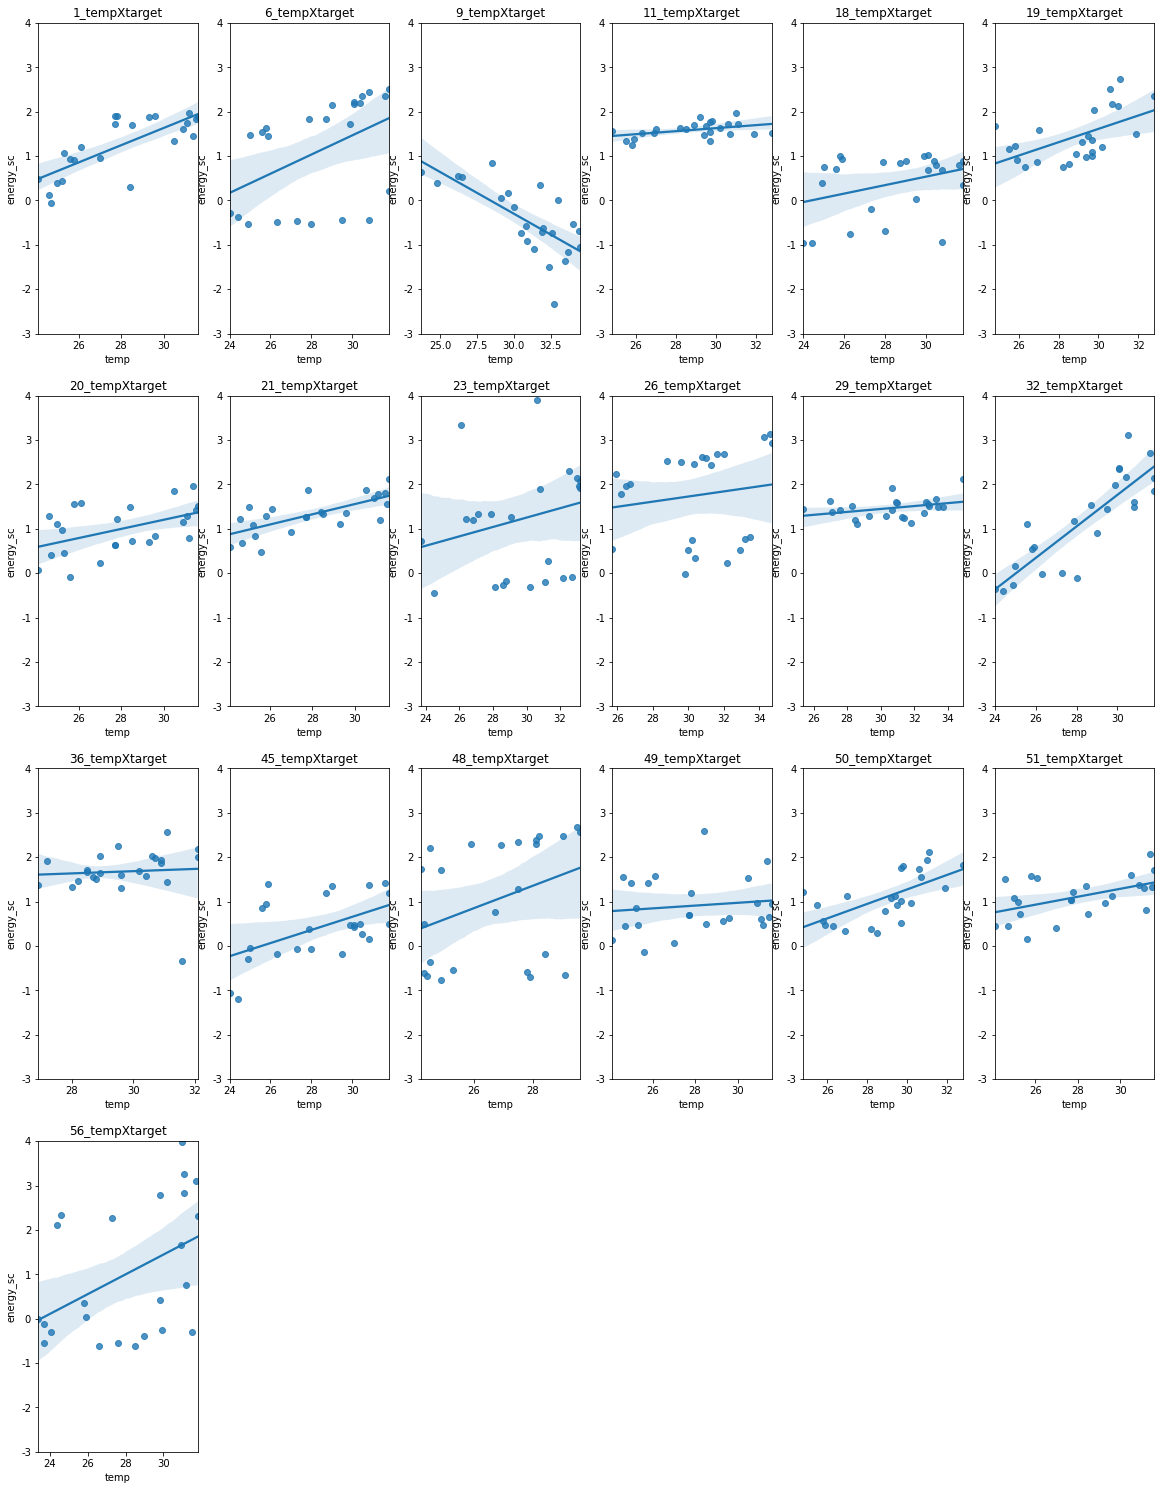

In [39]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(peak_df_0_8.num.unique()):
    plt.subplot(6, 6, i+1)
    plt.title("{}_tempXtarget".format(n))
    sns.regplot(data=peak_df_0_8.loc[peak_df_0_8.num == n], x='temp', y='energy_sc')
    plt.ylim(top=4, bottom=-3)

월 별 피크 시간대(14시)의 비전기 냉방 시설 설치 유무별 전력 사용량을 시각화해보았다.

Cooler를 설치한 건물과 설치하지 않은 건물의 뚜렷한 차이는 보이지 않지만 

Cooler를 설치한 건물은 그렇지 않은 건물에 비해 전력 사용량이 높게 형성되어 있다.

즉, **Cooler를 설치한 건물들은 전력 사용량이 많은 건물들일 가능성이 높다.**

비전기 냉방 시설(Cooler)을 설치하면 그만큼 전력 사용량이 줄어들어 최종적으로 전력 사용량이 적은 건물일 것이라고 예상했는데,

이미 전력을 많이 사용하고 있어 비전기 냉방 시설까지 도입한 것으로 유추해볼 수 있다.

-----------------

# 4-8, 4-9 부분은 수정 예정입니다 !!!

## 4-8. 태양광 설치 여부에 따른 전력 사용량

- 태양광 유무에 따라 전력사용량, 불쾌지수, 태양광 발전량을 함께 비교
- sun : 일조
- solar : 태양광보유 여부 (설치 : 1, 미설치 : 0)
- solar power : 태양광 발전량

In [40]:
#태양광 발전량 컬럼 생성
train['solar power'] =  train['sun'] * train['solar'] * train['precipitation'].map(lambda x : np.exp(-x)) * train['windspeed'] / train['humidity'] * 100

In [41]:
train[train['solar'] == 1]

,num,date_time,energy,temp,windspeed,humidity,precipitation,sun,cooler,solar,...,day,hour,weekday,weekend,THI,sensible,CDH,dayofyear,energy_sc,solar power
4080,3,2020-06-01 00:00:00,3183.62,17.00,2.00,100.00,1.10,0.00,1.00,1.00,...,1,0,0,0,62.60,17.33,-9.00,153,-1.06,0.00
4081,3,2020-06-01 01:00:00,3171.64,17.20,2.30,99.00,0.10,0.00,1.00,1.00,...,1,1,0,0,62.93,17.43,-17.80,153,-1.13,0.00
4082,3,2020-06-01 02:00:00,3175.74,17.20,3.70,98.00,0.00,0.00,1.00,1.00,...,1,2,0,0,62.91,16.92,-26.60,153,-1.11,0.00
4083,3,2020-06-01 03:00:00,3194.86,16.70,3.10,99.00,0.00,0.00,1.00,1.00,...,1,3,0,0,62.04,16.51,-35.90,153,-1.00,0.00
4084,3,2020-06-01 04:00:00,3198.53,16.90,3.50,98.00,0.00,0.00,1.00,1.00,...,1,4,0,0,62.37,16.62,-45.00,153,-0.98,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19:00:00,4114.37,27.80,2.30,68.00,0.00,0.70,1.00,1.00,...,24,19,0,0,77.81,29.90,4.30,237,1.84,2.37
122396,60,2020-08-24 20:00:00,3975.70,27.30,1.20,71.00,0.00,0.00,1.00,1.00,...,24,20,0,0,77.45,29.39,3.10,237,1.50,0.00
122397,60,2020-08-24 21:00:00,3572.21,27.30,1.80,71.00,0.00,0.00,1.00,1.00,...,24,21,0,0,77.45,29.34,2.60,237,0.53,0.00
122398,60,2020-08-24 22:00:00,3299.18,27.10,1.80,74.00,0.00,0.00,1.00,1.00,...,24,22,0,0,77.52,29.11,2.40,237,-0.13,0.00


In [42]:
print('태양광 설치 건물 번호 :', train[train['solar'] == 1]['num'].unique())

태양광 설치 건물 번호 : [ 3  4  8  9 12 14 16 21 23 24 26 27 30 34 36 37 38 39 40 42 43 44 45 47
 51 52 55 56 60]


## 4-9. 기온, 불쾌지수에 따른 전력 사용량

In [43]:
# THI 80 이상이면 50% 정도 불쾌감을 느낌
train['feel_THI'] = train['THI'].map(lambda x : 1 if x > 80 else 0)
train['feel_THI'].value_counts()

0    112635
1      9765
Name: feel_THI, dtype: int64

In [44]:
train['THI_c']=pd.cut(train.THI, bins=[50, 68, 75, 80, 90], labels=["Low", "Ordinary", "High", "Very High"])

train['THI_c'].unique()

['Low', 'Ordinary', 'High', 'Very High']
Categories (4, object): ['Low' < 'Ordinary' < 'High' < 'Very High']

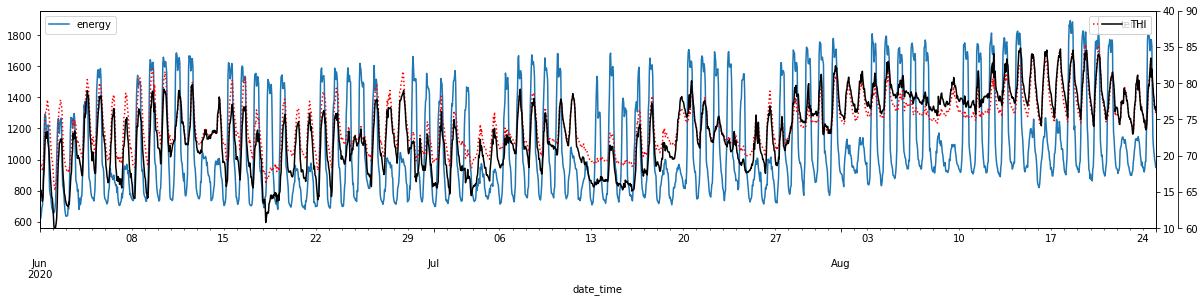

In [45]:
i = 13

fig, ax1 = plt.subplots(figsize = (20, 4))
ax2 = ax1.twinx()
ax3 = ax1.twinx()
rspine = ax3.spines['right']
rspine.set_position(('axes', 1.02))
# ax3.set_frame_on(True)
# ax3.patch.set_visible(False)
train[train['num'] == i].plot(x = 'date_time', y = ['energy'], ax = ax1)
train[train['num'] == i].plot(x = 'date_time', y = ['temp'], ax = ax2, color = 'r', ls = 'dotted')
train[train['num'] == i].plot(x = 'date_time', y = ['THI'], ax = ax3, color = 'k')

ax2.set_ylim(10, 40)
ax3.set_ylim(60, 90)

plt.show()

----------------------

## 4-10. 건물들의 요일별, 시간대별 전력 사용량

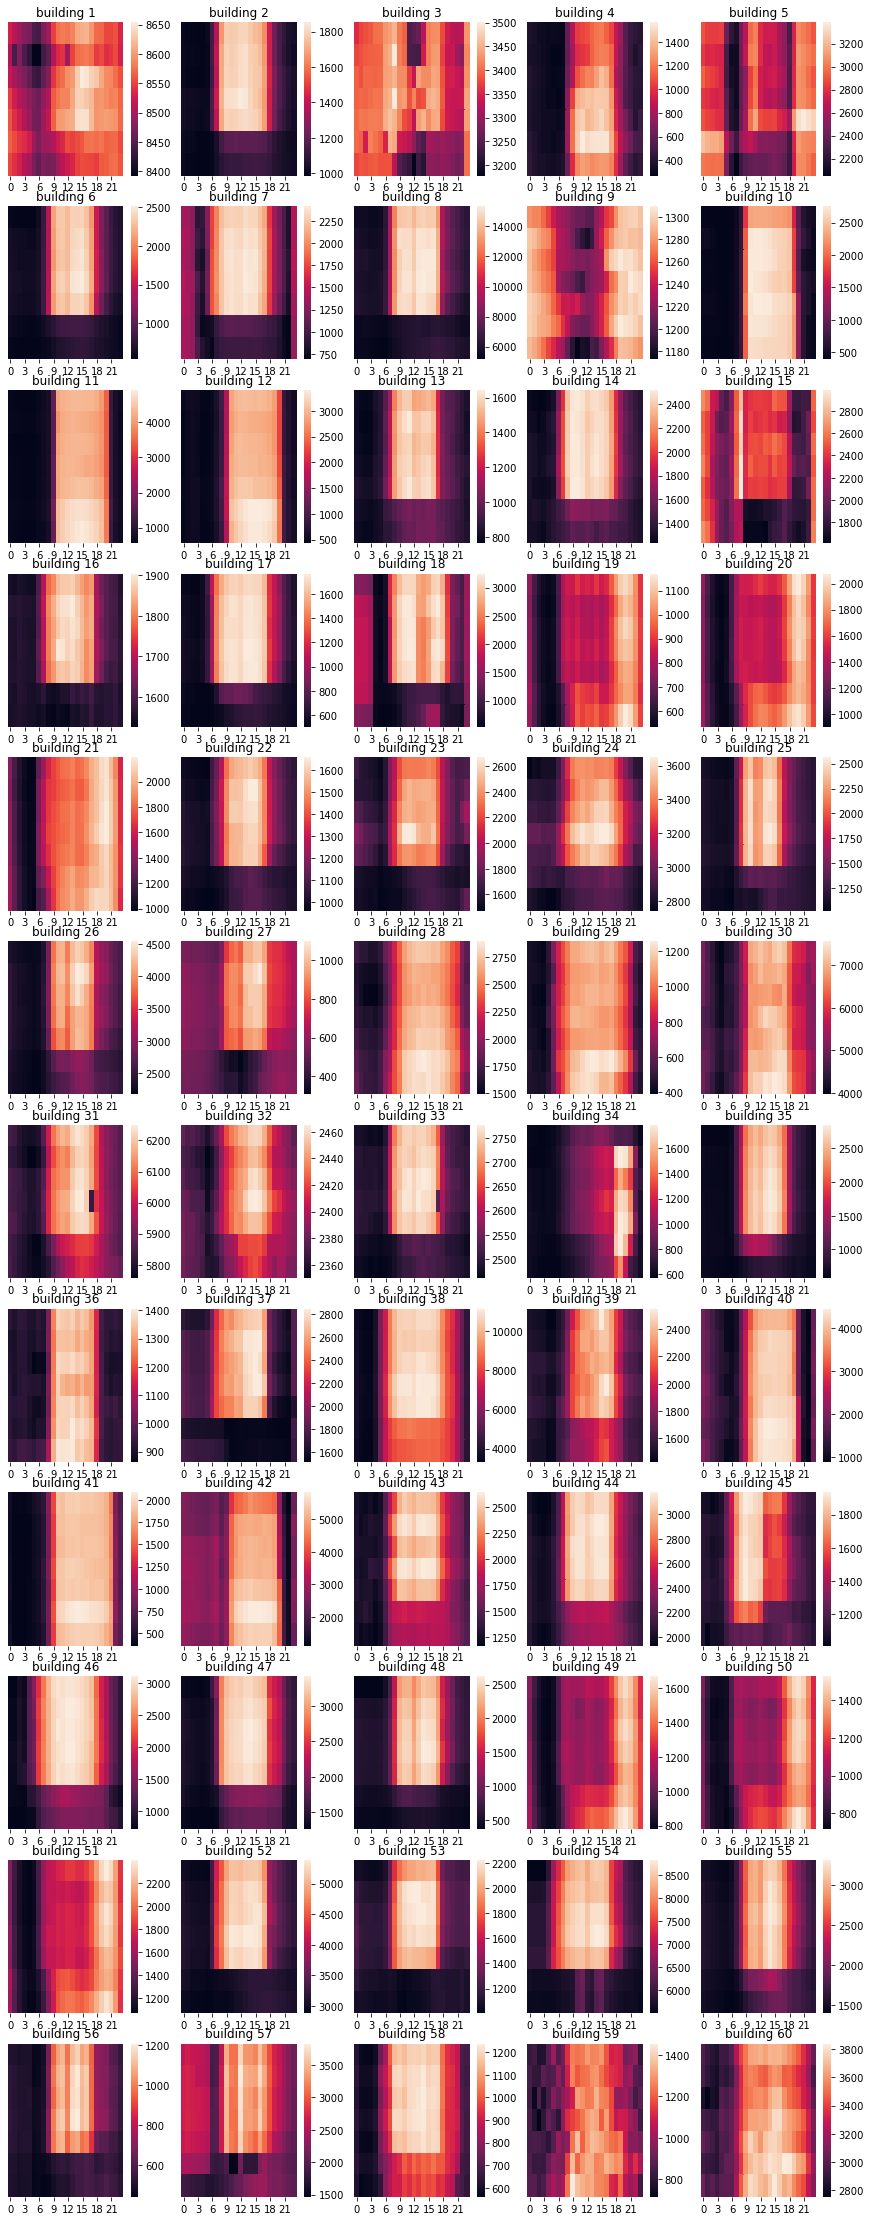

In [46]:
fig = plt.figure(figsize = (15, 40))
for num in train['num'].unique():
    df = train[train.num == num]
    df = df.groupby(['weekday', 'hour'])['energy'].mean().reset_index().pivot('weekday', 'hour', 'energy')
    plt.subplot(12, 5, num)
    sns.heatmap(df)
    plt.title(f'building {num}')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])

건물별로 상이한 패턴이 보이는데, 대표적으로 두 가지 패턴이 보인다.

- 평일 낮에만 전력사용량이 높은 건물


- 평일 주말 상관없이 낮에만 전력사용량이 높은 건물

이처럼 60개의 건물중에서도 비슷한 양상을 보이는 건물들이 있기 때문에

위의 히트맵에서 사용한 요일별, 시간대별 전력 사용량 지표를 활용해 건물들을 군집화하여

**군집 별 분석**을 진행해보고자 한다.

# 5. 군집 분석

## 5-1.  군집화 지표

### 5-1-1. 요일 별 전력량 median

In [47]:
by_weekday = train.groupby(['num', 'weekday'])["energy"].median().reset_index()
by_weekday = by_weekday.pivot('num', 'weekday', 'energy').reset_index()

In [48]:
by_weekday.head()

weekday,num,0,1,2,3,4,5,6
0,1,8565.59,8552.63,8567.21,8574.34,8563.00,8535.78,8521.52
1,2,1261.01,1304.10,1303.78,1318.36,1300.05,1074.55,1056.73
2,3,3369.36,3351.83,3381.48,3382.67,3374.50,3260.74,3250.80
3,4,538.49,547.99,554.26,582.98,612.36,602.64,608.26
4,5,2761.99,2732.18,2730.24,2650.75,2880.79,2747.74,2585.95


### 5-1-2. 시간 별 전력량 median

In [49]:
by_hour = train.groupby(['num', 'hour'])["energy"].median().reset_index()
by_hour = by_hour.pivot("num", "hour", "energy").reset_index().drop('num', axis=1)

In [50]:
by_hour.head()

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,8546.47,8526.38,8515.37,8505.00,8498.52,8458.34,8458.34,8480.38,8501.11,8541.94,...,8600.26,8607.38,8606.09,8598.96,8576.28,8586.00,8573.69,8577.58,8577.58,8558.78
1,1008.29,1001.16,993.71,987.88,983.99,991.44,1111.64,1318.36,1612.87,1711.37,...,1707.48,1697.11,1693.22,1622.27,1367.28,1204.96,1124.60,1078.92,1039.07,1021.25
2,3274.88,3272.40,3262.90,3276.29,3291.30,3293.24,3320.78,3341.20,3363.12,3373.38,...,3388.34,3385.15,3406.21,3394.87,3334.18,3295.51,3290.76,3283.52,3283.74,3327.59
3,372.82,355.10,344.30,335.23,309.31,309.31,308.02,324.86,647.57,899.86,...,1294.70,1288.22,1236.38,1121.47,917.57,748.22,566.35,479.52,405.22,422.50
4,2999.81,2920.32,2919.89,2912.98,2890.08,2407.10,2198.88,2095.20,2386.80,2557.01,...,2630.88,2667.60,2584.22,2552.26,2344.90,2788.99,3132.00,3111.70,3091.82,3013.20


### 5-1-3. 요일, 시간 별 전력 사용량의 median

In [51]:
df_wh = pd.concat([by_weekday, by_hour], axis=1) # 열 방향으로 합치기
columns = ["num"] + ["day" + str(i) for i in range(7)] + ["hour" + str(i) for i in range(24)]
df_wh.columns = columns

df_wh.head()

,num,day0,day1,day2,day3,day4,day5,day6,hour0,hour1,...,hour14,hour15,hour16,hour17,hour18,hour19,hour20,hour21,hour22,hour23
0,1,8565.59,8552.63,8567.21,8574.34,8563.00,8535.78,8521.52,8546.47,8526.38,...,8600.26,8607.38,8606.09,8598.96,8576.28,8586.00,8573.69,8577.58,8577.58,8558.78
1,2,1261.01,1304.10,1303.78,1318.36,1300.05,1074.55,1056.73,1008.29,1001.16,...,1707.48,1697.11,1693.22,1622.27,1367.28,1204.96,1124.60,1078.92,1039.07,1021.25
2,3,3369.36,3351.83,3381.48,3382.67,3374.50,3260.74,3250.80,3274.88,3272.40,...,3388.34,3385.15,3406.21,3394.87,3334.18,3295.51,3290.76,3283.52,3283.74,3327.59
3,4,538.49,547.99,554.26,582.98,612.36,602.64,608.26,372.82,355.10,...,1294.70,1288.22,1236.38,1121.47,917.57,748.22,566.35,479.52,405.22,422.50
4,5,2761.99,2732.18,2730.24,2650.75,2880.79,2747.74,2585.95,2999.81,2920.32,...,2630.88,2667.60,2584.22,2552.26,2344.90,2788.99,3132.00,3111.70,3091.82,3013.20


### 5-1-4. Scaling 

전력 사용량은 '4-1. 건물들의 평균 전력 사용량'을 통해 알 수 있듯이 

1000kWh부터 9000kWh까지 전력 사용량의 총량의 범위가 넓게 분포되어있다는 것을 알 수 있다.

본 분석에서는 절대적인 전력 사용량이 아닌 '요일과 시간대에 따른 전력 사용량의 **경향성**'에 따라 군집화할 것이기 때문에

분포의 범위 조정을 위해 위에서 구한 각각의 median 값에 **scaling**을 진행한다.

In [52]:
for i in range(len(df_wh)):
    # 요일별 전력 사용량 중앙값에 대해 normal scaling
    df_wh.iloc[i, 1:8] = (df_wh.iloc[i, 1:8] - df_wh.iloc[i, 1:8].mean()) / df_wh.iloc[i, 1:8].std()
    
    # 시간대별 전력 사용량 중앙값에 대해 normal scaling
    df_wh.iloc[i, 8:] = (df_wh.iloc[i, 8:] - df_wh.iloc[i, 8:].mean()) / df_wh.iloc[i, 8:].std()

### 5-1-5. Scaling 후 시각화

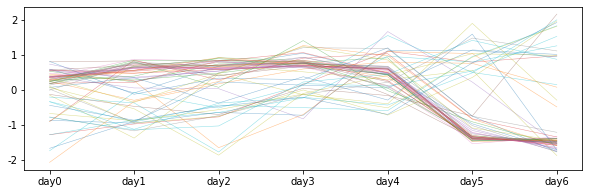

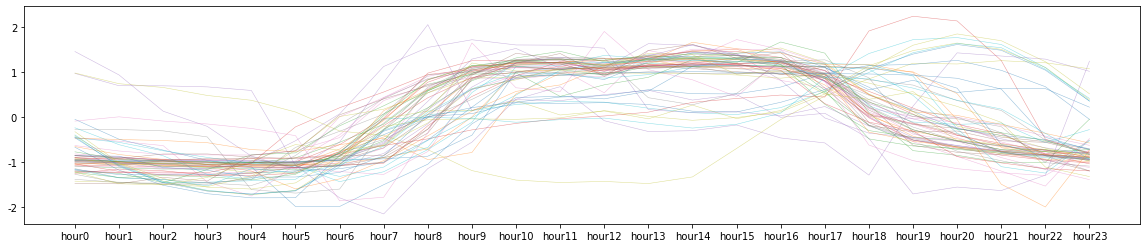

In [53]:
# 요일에 따른 건물별 전력량
fig = plt.figure(figsize=(10, 3))
for i in range(len(df_wh)):
    plt.plot(df_wh.iloc[i, 1:8], alpha=0.5, linewidth=0.5)

# 시간에 따른 건물별 전력량
fig = plt.figure(figsize=(20, 4))
for i in range(len(df_wh)):
    plt.plot(df_wh.iloc[i, 8:], alpha=0.5, linewidth=0.5)

- **요일별**

대부분 주말(day5, 6)로 갈수록 전력 사용량이 줄어들지만, 일부 건물들은 그대로 유지되거나 오히려 증가한다.

주중에 사용량이 많다면 회사, 주말에도 사용량이 많다면 식당이나 카페 등일 것 같다고 해석할 수 있다.

- **시간별**

대부분 오전 7시 - 6시 사이에 전력 사용량이 늘고, 그 이후엔 감소하는 경향을 보인다.

저녁에도 꾸준히 사용량이 는다면 식당, 유흥시설과 같은 곳이라고 해석할 수 있다.

## 5-2. K-means Clustering

- elbow method를 통해 최적의 클러스터 개수 결정


- K-means 클러스터링은 클러스터 내 오차제곱합(SSE)의 값이 최소가 되도록 클러스터의 중심을 결정하는데, 

  클러스터의 개수를 늘려가며 SSE 값을 그래프로 그려본다.


- 이 그래프 모양에서 팔꿈치에 해당하는 부분이 우리가 구하고자 하는 최적의 클러스터 개수이다.

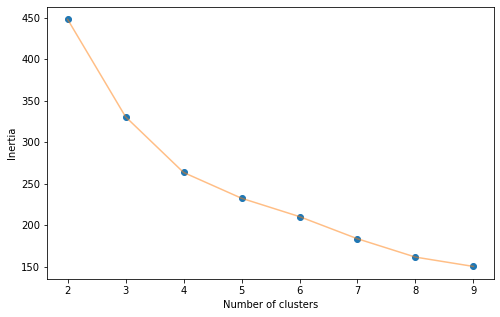

In [54]:
from sklearn.cluster import KMeans

def elbow_method(n_clusters, data):
    SSE = [] # sum of squared distance
    
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(data)
        SSE.append(kmeans.inertia_) # 계산된 SSE값
    
    plt.figure(1, figsize=(8, 5))
    plt.plot(n_clusters, SSE, 'o')
    plt.plot(n_clusters, SSE, '-', alpha=0.5)
    plt.xlabel("Number of clusters")
    plt.ylabel("Inertia")


elbow_method([2, 3, 4, 5, 6, 7, 8, 9], df_wh.iloc[:, 1:]) # num열 제외 모든 데이터

elbow point 는 4를 가리키고 있으므로 군집의 개수는 4로 지정한다.

In [55]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_cls = kmeans.fit_predict(df_wh.iloc[:, 1:])

### 5-2-1. 군집별 line 그래프

In [56]:
df_clust = df_wh.copy()  # train_clust 객체 생성
df_clust["kmeans_cls"] = kmeans_cls # cluster 열 추가
df_clust["kmeans_cls"] = df_clust["kmeans_cls"].map({0:1, 1:3, 2:2, 3:0})

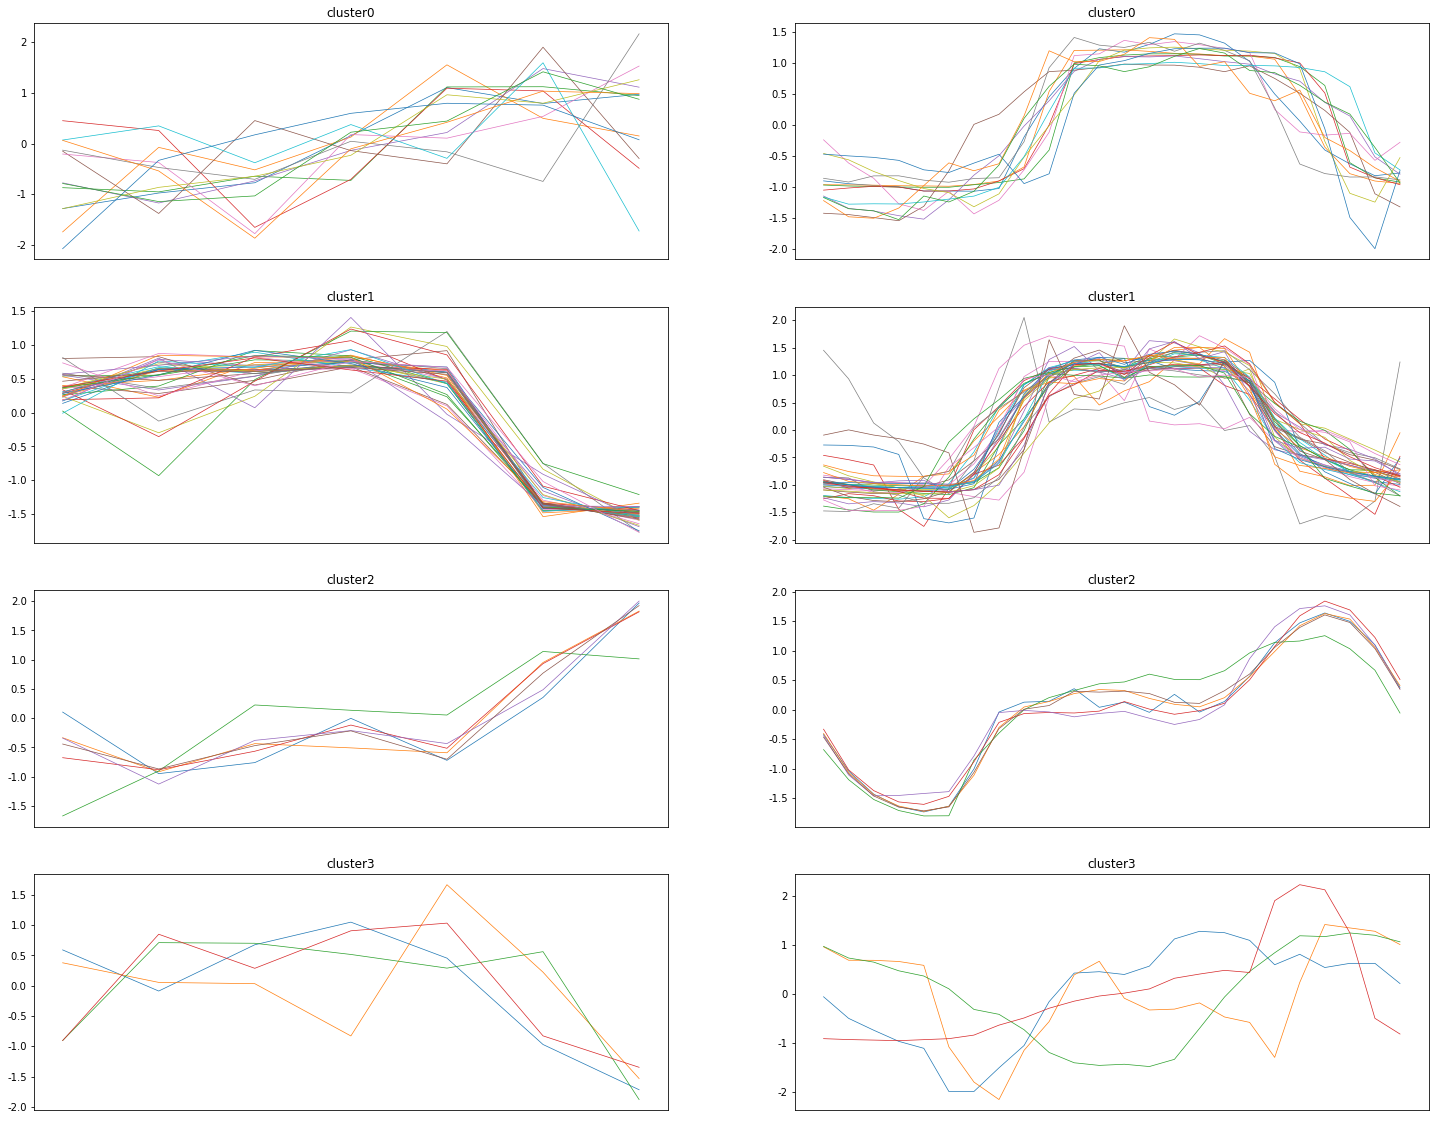

In [57]:
n_cls = df_clust["kmeans_cls"].nunique()

fig = plt.figure(figsize=(25, 20))

for c in range(n_cls):
    temp = df_clust[df_clust["kmeans_cls"] == c]
    
    # day  (왼쪽 그래프)
    plt.subplot(n_cls, 2, 2*c+1)
    plt.subplots_adjust(hspace=0.2)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i, 1:8], linewidth=0.7)
        plt.title(f'cluster{c}')
        plt.xticks([])
        plt.xticks() 

    # hour   (오른쪽 그래프)
    plt.subplot(n_cls, 2, 2*c+2)
    plt.subplots_adjust(hspace=0.2)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i, 8:-1], linewidth=0.7)
        plt.title(f'cluster{c}')
        plt.xticks([])
#         plt.xticks() # 눈금 보고싶다면

- **cluster 0**

요일이 지날수록 전력 샤용량이 증가한다.

9시-18(9)시까지 사용량이 많다.


- **cluster 1**

평일엔 사용량이 많지만 주말이 되면 확연히 감소한다.


- **cluster 2**

주말에 사용량이 현저하게 증가한다.

오전에 한 번, 저녁 5시 이후에 한 번 사용량이 급증한다.


- **cluster 3**

주말에 사용량이 감소한다.

오후에 사용량이 증가하는 듯 보이지만 뚜렷한 경향성이 나타나지 않는다.



### 5-2-2. 군집별 히트맵

In [58]:
train = train.merge(df_clust[["num", "kmeans_cls"]], on="num", how="left")
train.head()

,num,date_time,energy,temp,windspeed,humidity,precipitation,sun,cooler,solar,...,weekend,THI,sensible,CDH,dayofyear,energy_sc,solar power,feel_THI,THI_c,kmeans_cls
0,1,2020-06-01 00:00:00,8179.06,17.60,2.50,92.00,0.80,0.00,0.00,0.00,...,0,63.43,17.81,-8.40,153,-2.80,0.00,0,Low,3
1,1,2020-06-01 01:00:00,8135.64,17.70,2.90,91.00,0.30,0.00,0.00,0.00,...,0,63.57,17.78,-16.70,153,-3.13,0.00,0,Low,3
2,1,2020-06-01 02:00:00,8107.13,17.50,3.20,91.00,0.00,0.00,0.00,0.00,...,0,63.23,17.44,-25.20,153,-3.35,0.00,0,Low,3
3,1,2020-06-01 03:00:00,8048.81,17.10,3.20,91.00,0.00,0.00,0.00,0.00,...,0,62.54,16.96,-34.10,153,-3.80,0.00,0,Low,3
4,1,2020-06-01 04:00:00,8043.62,17.00,3.30,92.00,0.00,0.00,0.00,0.00,...,0,62.40,16.80,-43.10,153,-3.84,0.00,0,Low,3


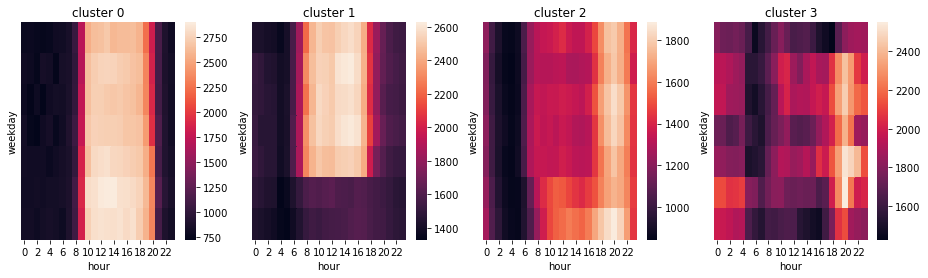

In [59]:
fig = plt.figure(figsize=(20, 4))

for c in range(n_cls):
    temp = train[train["kmeans_cls"] == c]
    temp = temp.groupby(["weekday", "hour"])["energy"].median().reset_index().pivot("weekday", "hour", "energy")
    plt.subplot(1, 5, c+1)
    sns.heatmap(temp)
    plt.title(f'cluster {c}')
    plt.yticks([])

5-2-1의 결과와 함께 종합해보면,

- **cluster 0**

매일 8-20시에 전력 사용량이 크다.

늘 전력을 소비하는 식당, 카페, 상점, 대형 복합 쇼핑몰이라고 추정할 수 있다.


- **cluster 1**

평일 8-20시에 전력 사용량이 많고, 주말에 전력 사용량이 작다. 

기업체로 추정할 수 있다.

- **cluster 2**

매일 저녁 16-22시에 전력 사용량이 크다. 

밤에 운영되는 주점, 유흥시설이라고 추정할 수 있다.

평일보단 주말에 소모량이 약간 더 많다.


- **cluster 3**

오전보단 오후나 저녁으로 갈수록 전력 사용량이 커진다. 



그래프와 히트맵으로 시각화한 결과,

군집 내 유사도는 높으며 군집 간 유사도는 낮기 때문에 군집화가 잘 되었다고 할 수 있다.

따라서 **도출된 4가지 군집별로 분석**하고자 한다.

## 5-3. 군집 별 특성 분석

### 5-3-1. 군집별 평균 전력 사용량 

In [60]:
energy_mean = train.groupby("kmeans_cls")["energy"].mean()
energy_mean

kmeans_cls
0   2170.39
1   2431.57
2   1315.26
3   3353.81
Name: energy, dtype: float64

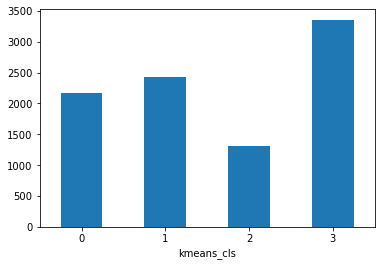

In [61]:
energy_mean.plot.bar(rot=0);

cluster3 군집의 평균 전력 사용량이 가장 많다.

### 5-3-2. 군집별 전력사용량과 기후 요소 상관관계

In [62]:
temp0 = train[train['kmeans_cls'] == 0][['energy','temp','windspeed','humidity','precipitation','sun']]
temp1 = train[train['kmeans_cls'] == 1][['energy','temp','windspeed','humidity','precipitation','sun']]
temp2 = train[train['kmeans_cls'] == 2][['energy','temp','windspeed','humidity','precipitation','sun']]
temp3 = train[train['kmeans_cls'] == 3][['energy','temp','windspeed','humidity','precipitation','sun']]

In [63]:
temp0.corrwith(temp0['energy'], method = 'spearman')

energy           1.00
temp             0.28
windspeed        0.38
humidity        -0.10
precipitation   -0.03
sun              0.30
dtype: float64

In [64]:
temp1.corrwith(temp1['energy'], method = 'spearman')

energy           1.00
temp             0.21
windspeed        0.09
humidity        -0.10
precipitation    0.00
sun              0.17
dtype: float64

In [65]:
temp2.corrwith(temp2['energy'], method = 'spearman')

energy           1.00
temp             0.48
windspeed        0.06
humidity        -0.15
precipitation    0.02
sun              0.09
dtype: float64

In [66]:
temp3.corrwith(temp3['energy'], method = 'spearman')

energy           1.00
temp             0.09
windspeed        0.24
humidity        -0.04
precipitation   -0.00
sun             -0.01
dtype: float64

**요약** 

|항목|Cluster 0|Cluster 1|Cluster 2|Cluster 3| 
|:---:|:---:|:---:|:---:|:---:| 
|기온(°C)|0.09|**0.21**|**0.28**|**0.48**| 
|풍속(m/s)|**0.24**|0.09|**0.38**|0.06| 
|습도(%)|-0.04|-0.10|-0.10|-0.15| 
|강수량(mm)|-0.00|0.00|-0.03|-0.02| |
일조(hr)|-0.01|0.17|**0.30**|0.09|

### 5-3-3. 군집별 전력사용량과 기후 요소 상관관계 히트맵

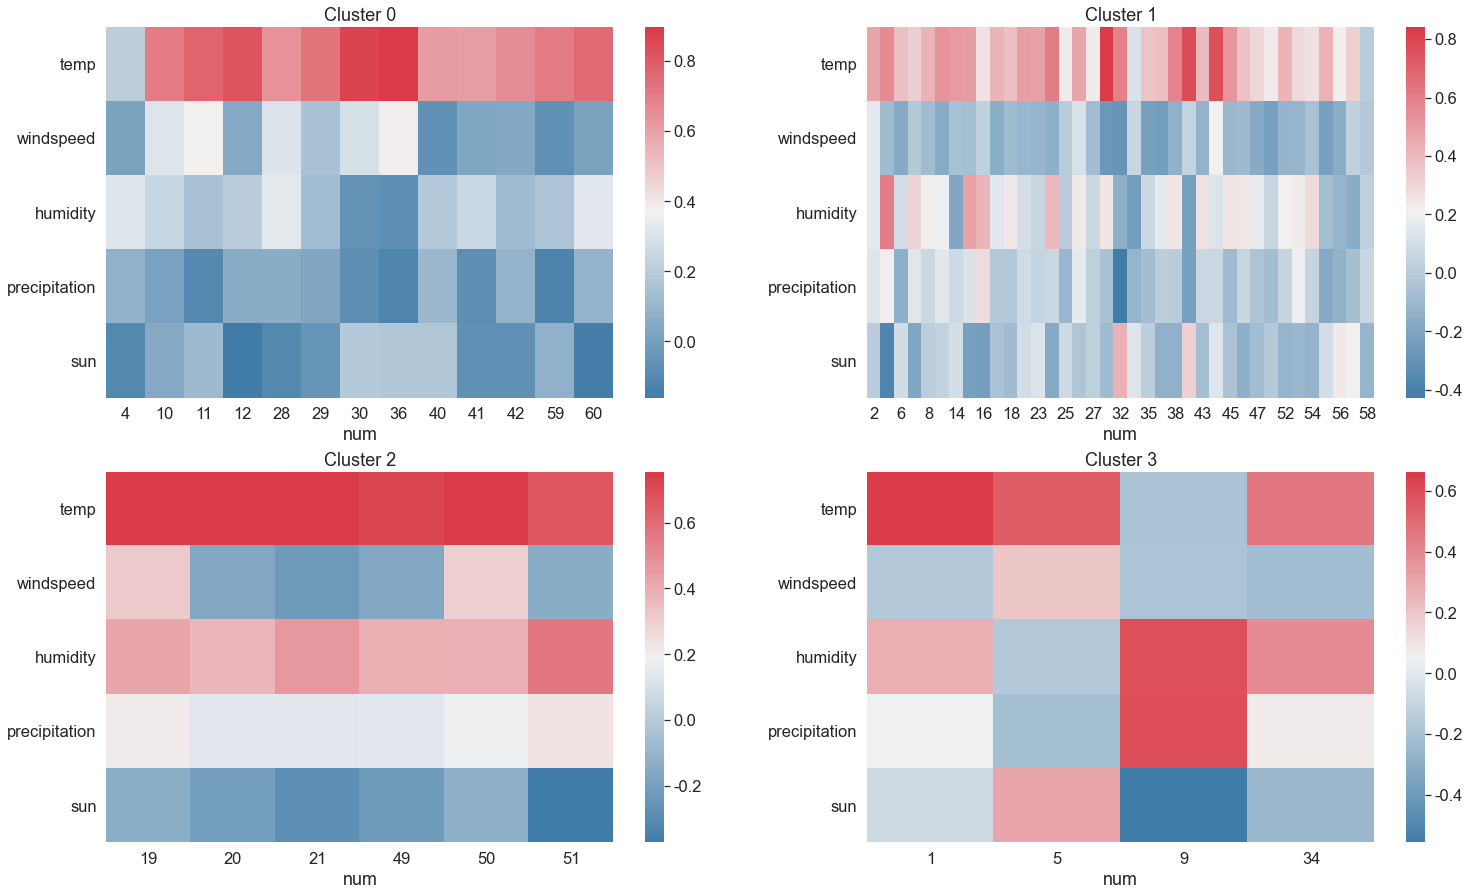

In [67]:
corrs4 = []
for c in range(4):
    data = train[train['kmeans_cls'] == c]
    nums = data['num'].unique()
    data = data.groupby(['num', 'date'])[['energy','temp','windspeed','humidity','precipitation','sun']].mean().reset_index()
    
    corrs = []
    for num in nums:
        corr = []
        corr.append(num)
        for col in ['temp','windspeed','humidity','precipitation','sun']:
            corr.append(spearmanr(data.loc[data.num == num, 'energy'], data.loc[data.num == num, col]).correlation)
        corrs.append(corr)
    corrs4.append(corrs)


fig = plt.figure(figsize = (25, 15), constrained_layout=False)
for i, corrs in enumerate(corrs4):
    data = pd.DataFrame(np.array(corrs), columns = ['num','temp','windspeed','humidity','precipitation','sun'])
    data['num'] = data['num'].astype(int)
    data = data.set_index('num')

    sns.set(font_scale = 1.5)
    plt.subplot(2, 2, i+1)
    sns.heatmap(data.transpose(), cmap = sns.diverging_palette(240,10, as_cmap = True))
    plt.title(f'Cluster {i}')

- **Cluster 0**

기온과 높은 양의 상관관계가 있으며, 다른 군집들에 비해 기후와 상관이 있는 군집임을 유추할 수 있다.

- **Cluster 1**

전체적으로 기후와 상관이 없지만 기온과 약한 양의 상관관계가 있다.

- **Cluster 2**

군집 중 기온과 가장 높은 양의 상관관계를 가지는 군집이다.

기온과 습도와 비교적 높은 양의 상관관계를 가진다.

건물마다 풍속과의 상관관계가 상이하다.

- **Cluster 3**

뚜렷한 군집 특성이 드러나지 않는다.

### 5-3-4. 군집별 전력사용량과 개별 기후 요소 상관관계 시각화

In [68]:
# 기후 요소 상관관계를 시각화해주는 함수
# 상관관계가 없다고 할 수 있는 습도, 강수량에 대해서는 시각화하지 않음.

def draw_4chart(data, col = 'temp'):
    fig = plt.figure(figsize = (20, 4))
    for c in range(4):
        temp = data[data.kmeans_cls == c]
        temp = temp.groupby([col])[['energy']].mean().reset_index()
        plt.subplot(1, 5, c+1)
        sns.regplot(data = temp, x = col, y = 'energy')
        plt.title(f'cluster {c}')
        plt.xlabel('')
        plt.ylabel('')

**기온**

- Cluster 3을 제외한 Cluster 0, 1, 2에서 기온이 증가함에 따라 전력 사용량도 함께 증가하는 모습을 확인할 수 있다.

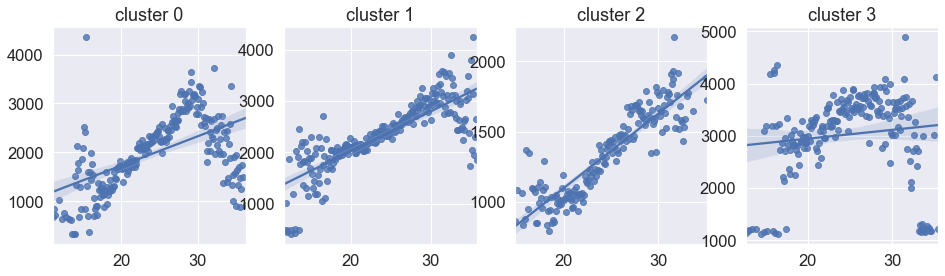

In [69]:
draw_4chart(train, 'temp')

**풍속**

- Cluster 0에서 풍속이 빠를수록 전력 사용량이 증가하는 경향이 있다.
- Cluster 1, 2에서 풍속이 빠를수록 전력 사용량이 감소하는 경향이 있다.

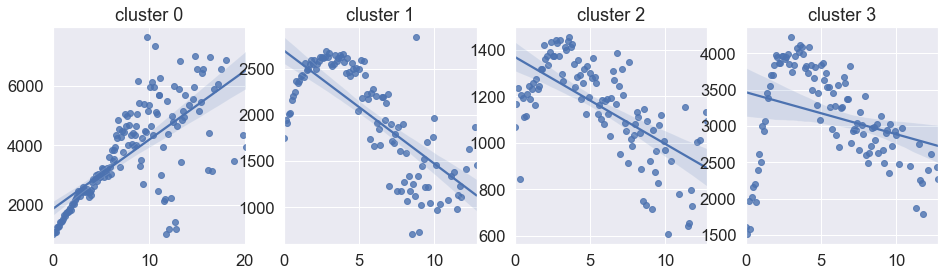

In [70]:
draw_4chart(train, 'windspeed')

**일조**

- cluster0의 경우 경미한 양의 상관관계를 보인다고 할 수 있다.

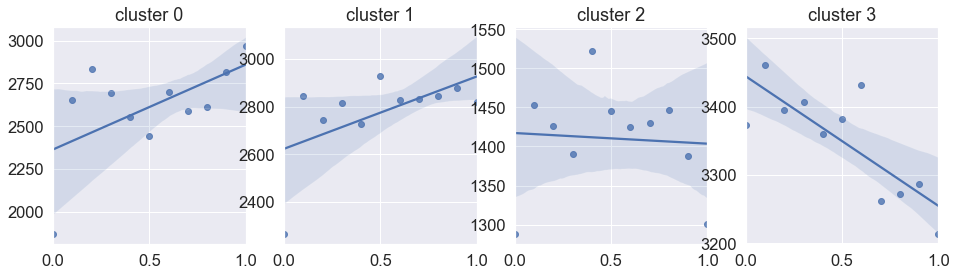

In [71]:
draw_4chart(train, 'sun')

### 5-3-5. CDH, THI, sensible과 전력 사용량의 상관관계
- 새롭게 만든 변수인 CDH, THI(불쾌지수), sensible(체감온도)이 전력 사용량과 얼마나 상관관계가 있는지 확인한다.

In [72]:
df_0 = train[train["kmeans_cls"] == 0]
df_1 = train[train["kmeans_cls"] == 1]
df_2 = train[train["kmeans_cls"] == 2]
df_3 = train[train["kmeans_cls"] == 3]

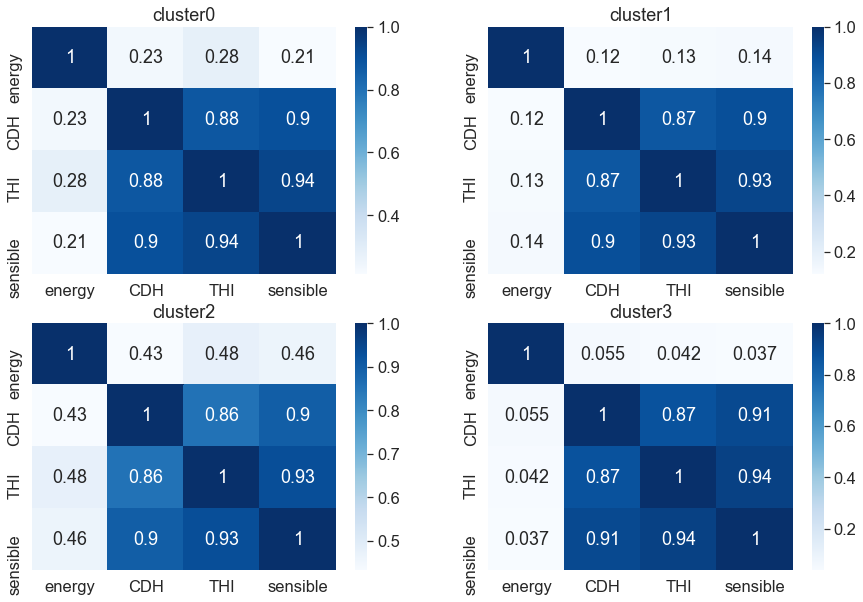

In [73]:
df_0_new = df_0[["energy", "CDH", "THI", "sensible"]]
df_1_new = df_1[["energy", "CDH", "THI", "sensible"]]
df_2_new = df_2[["energy", "CDH", "THI", "sensible"]]
df_3_new = df_3[["energy", "CDH", "THI", "sensible"]]

fig = plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.title('cluster0')
sns.heatmap(df_0_new.corr(), cmap="Blues", annot=True)

plt.subplot(2, 2, 2)
plt.title('cluster1')
sns.heatmap(df_1_new.corr(), cmap="Blues", annot=True)

plt.subplot(2, 2, 3)
plt.title('cluster2')
sns.heatmap(df_2_new.corr(), cmap="Blues", annot=True)

plt.subplot(2, 2, 4)
plt.title('cluster3')
sns.heatmap(df_3_new.corr(), cmap="Blues", annot=True)

plt.show();

cluster0, cluster1, cluster3에서 CDH, THI, sensible과 전력 사용량은 낮은 상관관계를 보인다.

그에 반면 **cluster2은 세 변수 모두 상관계수가 0.4 이상**으로 다른 군집들에 비해 높은 양의 상관관계를 보인다.

### 🧤 5-3-6. CDH와 전력 사용량의 상관관계

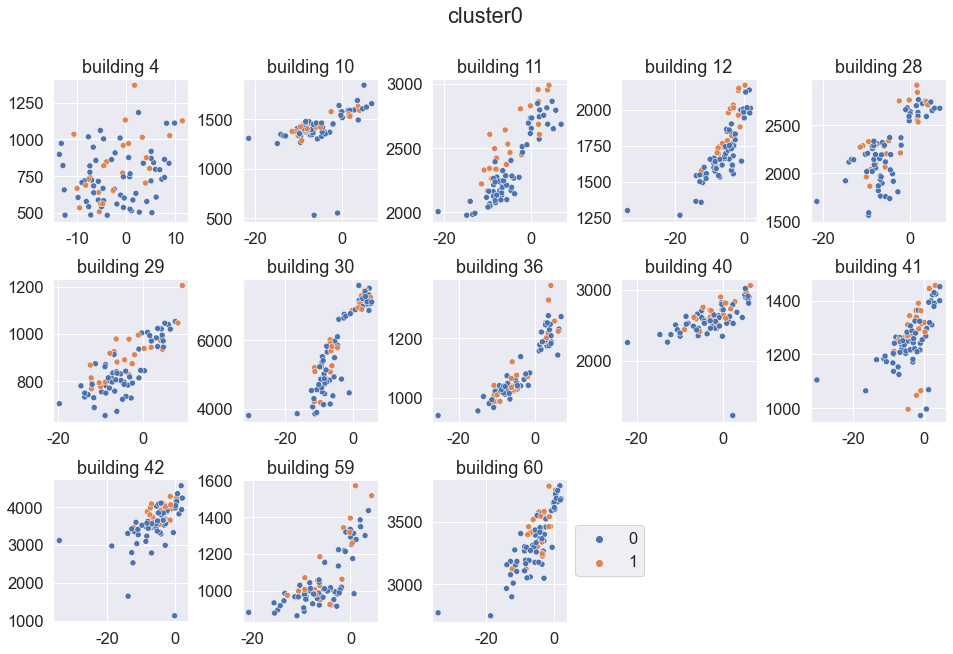

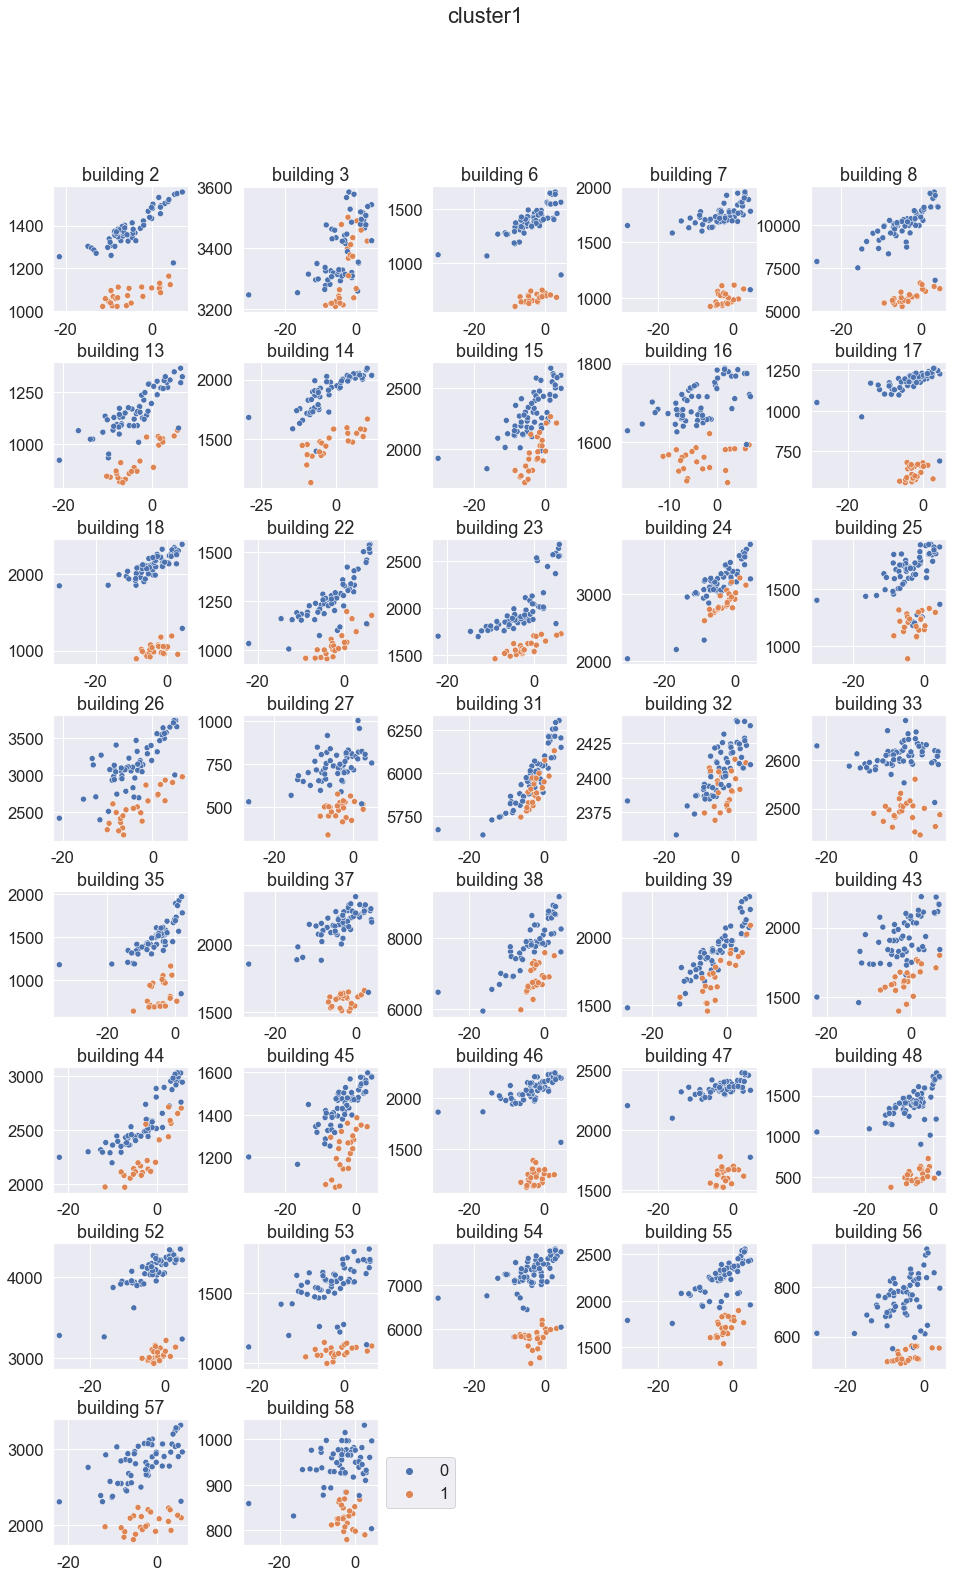

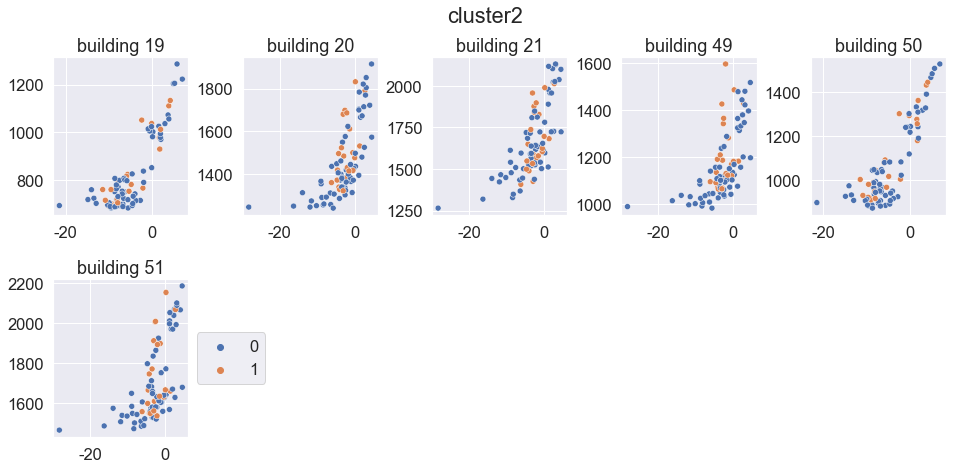

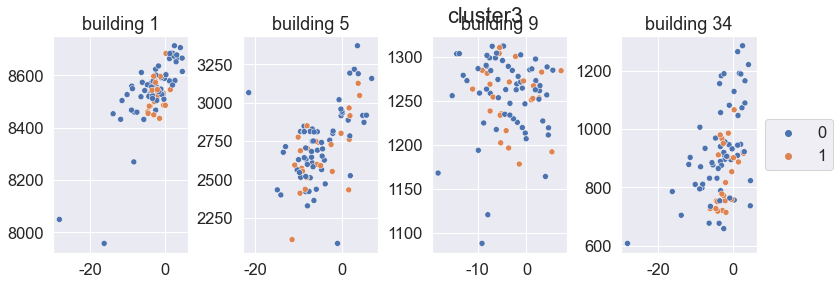

In [74]:
for c in range(n_cls):
    temp1 = train[train["kmeans_cls"] == c]
    nums = np.unique(temp1.num)
    n_nums = len(nums)
    fig = plt.figure(figsize = (16, 3*(n_nums//5+1)+1))
    plt.suptitle(f'cluster{c}')
    for i, num in enumerate(nums):
        temp2 = temp1[temp1.num == num]
        temp2_tg = temp2.groupby(['num', 'date', 'weekend'])[['energy']].mean().reset_index()
        temp2_cdh = temp2.groupby(['num', 'date', 'weekend'])[['CDH']].mean().reset_index()
        temp2 = temp2_tg.merge(temp2_cdh, on=['num', 'date', 'weekend'], how='left')
        plt.subplot(n_nums//5+1, 5, i+1)
        sns.scatterplot(data = temp2, x='CDH', y='energy', hue='weekend')
        plt.legend([],[], frameon=False)
        plt.title(f'building {num}')
        plt.ylabel('')
        plt.xlabel('')
        plt.subplots_adjust(wspace = 0.4, hspace = 0.4)
        
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

cluster 0, 3의 건물들은 일평균 CDH와 일평균 전력 사용량과 상관관계가 있다는 것을 유추해볼 수 있다.

CDH가 올라갈수록 전력 소모량도 증가하는 양상을 보인다.

특히 cluster1은 평일과 주말의 전력 소모량이 확연한 차이가 있다.

cluster3은 CDH의 변화와 전력 소모량의 상관관계가 크게 포착되지 않는다.

### 🧤 5-3-7. 각 군집별 Cooler, Solar 유무와 전력 사용량의 관계

In [75]:
df = [df_0, df_1, df_2, df_3]

In [76]:
train.groupby(["kmeans_cls", "num"])["energy"].mean().reset_index().groupby(["kmeans_cls"])

In [77]:
cs_temp = train.groupby(['kmeans_cls', "num"]).max().reset_index().groupby(["kmeans_cls"])["cooler", "solar"].sum()
cs_temp

<ipython-input-77-26d5bed41830>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  cs_temp = train.groupby(['kmeans_cls', "num"]).max().reset_index().groupby(["kmeans_cls"])["cooler", "solar"].sum()


,cooler,solar
kmeans_cls,,
0,10.00,7.00
1,29.00,18.00
2,0.00,2.00
3,2.00,2.00


In [78]:
# 한 건물당 레코드는 총 2040개
cs_temp["building"] = train.groupby(["kmeans_cls"])["num"].count() / 2040 # 클러스터 별로 13, 37, 6, 4개의 건물
cs_temp["cooler_rate"] = cs_temp.cooler / cs_temp.building
cs_temp["solar_rate"] = cs_temp.solar / cs_temp.building
cs_temp

,cooler,solar,building,cooler_rate,solar_rate
kmeans_cls,,,,,
0,10.00,7.00,13.00,0.77,0.54
1,29.00,18.00,37.00,0.78,0.49
2,0.00,2.00,6.00,0.00,0.33
3,2.00,2.00,4.00,0.50,0.50


**Cooler**
- Cluster 0, Cluster 1에 cooler가 많이 설치된 반면, Cluster 2에는 cooler가 설치되어 있지 않다.
- 이는 주간-야간에 골고루 전력 소모량이 많은 건물들(회사, 상가 등)엔 설치율이 높고, 야간에 전력 소모량이 많은 주점, 기업체들엔 설치율이 낮음을 알 수 있다.

**Solar**
- Solar는 모든 건물 유형에서 유사한 비율로 설치가 되어있는데, 주로 밤에 전력을 소모하는 Cluster 2의 경우 설치율이 상대적으로 낮다.

<ipython-input-79-ff28a5bcc414>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  sns.barplot(data=train.groupby(['kmeans_cls', "num"]).mean().reset_index().groupby(["kmeans_cls", "cooler"])["temp", "energy"].mean().reset_index(),
<ipython-input-79-ff28a5bcc414>:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  sns.barplot(data=train.groupby(['kmeans_cls', "num"]).mean().reset_index().groupby(["kmeans_cls", "solar"])["temp", "energy"].mean().reset_index(),


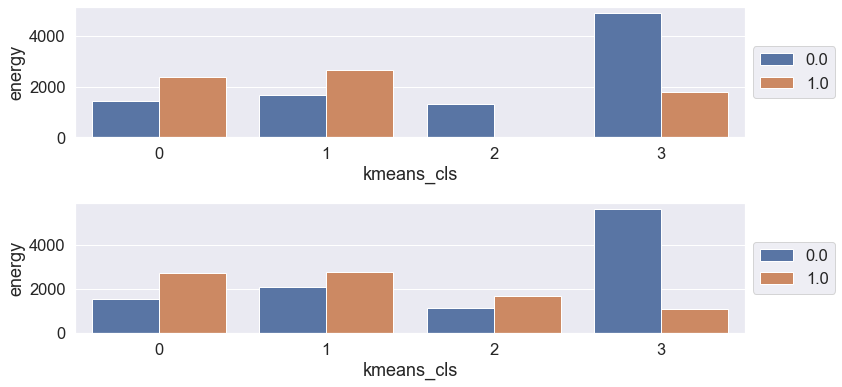

In [79]:
fig = plt.figure(figsize=(12, 6))

# 군집별 cooler 설치 유무 energy 평균량
plt.subplot(2, 1, 1)
sns.barplot(data=train.groupby(['kmeans_cls', "num"]).mean().reset_index().groupby(["kmeans_cls", "cooler"])["temp", "energy"].mean().reset_index(),
            x="kmeans_cls", y="energy", hue="cooler")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


# 군집별 cooler 설치 유무 solar 평균량
plt.subplot(2, 1, 2)
sns.barplot(data=train.groupby(['kmeans_cls', "num"]).mean().reset_index().groupby(["kmeans_cls", "solar"])["temp", "energy"].mean().reset_index(),
            x="kmeans_cls", y="energy", hue="solar")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplots_adjust(hspace=0.5)

plt.show()

- Cluster 0과 1은 cooler와 solar가 설치된 비율도 많았는데 그만큼 설치된 건물에서 전력 사용량도 높았다.
- Cluster 2와 3의 경우 cooler와 solar가 설치되지 않은 건물들에서 전력 사용량이 높게 나왔다.

## 🧤 5-4. 군집 분석 정리

- **cluster 0**

주말에 사용량이 감소

오후에 사용량이 증가하는 듯 보이지만 뚜렷한 경향성이 나타나지 않는다.

뚜렷한 군집특성이 드러나지 않는다.

CDH, THI, sensible과 전력 사용량은 낮은 상관관계

cooler가 설치되어 있는 비율이 많고, 설치된 건물에서 전력 사용량이 높다.

- **cluster 1**

평일엔 사용량이 많지만 주말이 되면 확연히 감소한다.

전체적으로 기후와 상관이 없지만 기온과 약한 양의 상관 관계가 있다.

대체로 기온과 습도의 영향을 많이 받는 건물들 -> 불쾌지수  연관

상대적으로 풍속의 영향이 적음

기온이 증가함에 따라 전력 사용량도 함께 증가하는 모습을 확인

풍속이 빠를수록 전력 사용량이 감소하는 경향

CDH, THI, sensible과 전력 사용량은 낮은 상관관계

cooler가 설치되어 있는 비율이 많고, 설치된 건물에서 전력 사용량이 높다.


- **cluster 2**

요일이 지날수록 전력 샤용량이 증가한다.

9시-18(9)시까지 사용량이 많다.

기온, 풍속, 일조와 다른 군집들에 비해 높은 양의 상관 관계가 있으며, 비교적 기후와 상관이 있는 군집임을 유추할 수 있다.

건물마다 습도 및 풍속의 영향이 상이함

풍속이 빠를수록 전력 사용량이 증가하는 경향이 있다.

CDH, THI, sensible과 약한 양의 상관관계

cooler가 설치되어 있는 건물이 존재하지 않는다. solar가 설치된 건물들에서 전력 사용량이 높다.


- **cluster 3**

주말에 사용량이 현저하게 증가한다.

오전에 한 번, 저녁 5시 이후에 한 번 사용량이 급증한다.

군집 중 기온과 가장 높은 양의 상관관계를 가지는 군집이다.

대체로 기온과 습도의 영향을 많이 받는 건물들

건물마다 풍속의 영향이 상이함

풍속이 빠를수록 전력 사용량이 감소하는 경향이 있다.

기온이 증가함에 따라 전력 사용량도 함께 증가하는 모습

CDH, THI, sensible 모두 상관계수가 0.4 이상 으로 다른 군집들에 비해 높은 양의 상관관계

cooler, solar의 설치 유무가 반반이고, 모두 설치되지 않은 건물들에서 전력 사용량이 높다.

## 위의 정리된 특징+새로운 데이터로 해당 군집은 어떤 건물일지(학교, 식당, 유흥주점 ..) 유추해보면 될 것 같아요!

### 아마 일별, 시간대별 전력 사용량이 가장 유추하기 좋은 지표일 것 같은데 다른 데이터(뉴스 기사, 논문 ..)가 있을 수도 있으니 한 번 찾아보고 붙일 수 있으면 붙이는게 좋을 것 같습니다!

# 6. 참고 링크

- https://dacon.io/competitions/official/235736/codeshare/2743?page=1&dtype=recent

- https://www.dacon.io/competitions/official/235736/codeshare/2844?page=2&dtype=recent

- https://dacon.io/competitions/official/235736/codeshare/2835?page=1&dtype=recent